**Problem**:

We need a good understanding of the T1DExi data. After having assessed the netiob script, and the study documentation some questions remain about how the columns relate. Especially the script often uses equivalent columns which makes it difficult. The analysis of the script output also leads to strong concerns about the validity of the output.

- Do we need all the columns or are they mostly redundant?
- Can we rely on the table as presented in T1DEXI ACRF_15Sept2022.pdf? or rather on the script?
- The script sometimes uses FATEST (test) and FACAT (category) depending on which pump is being looked at 670g and 770g?
- The script does not extract extended boluses in 770g, why?
- Is FASTRESN just a copy of the value in INSEXBOL or INSNMBOL and FAORRES (Basal)?
-  ...

We want to take a close look at the data itself.

**Goal**: Load xpt file into pandas in jupyter. Identify relevant columns and verify how they relate to another.

## Load the data

In [106]:
#imports

#notebook
import os
import sys
sys.path.append('../..')
import matplotlib.pyplot as plt
from src import cdf

# relevant for the class
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import isodate

In [76]:
#define path
t1dexi_path = os.path.join(os.getcwd(),'..','..','data','raw','T1DEXI')

### load device file

In [77]:
#load and preprocess dx file
dx = pd.read_sas(os.path.join(t1dexi_path,'DX.xpt'),encoding='latin-1').replace('', np.nan)
dx = dx.drop(columns=['DXSCAT','DXPRESP','STUDYID','DOMAIN','SPDEVID','DXSEQ','DXCAT','DXSCAT','DXSTRTPT','DXDTC','DXENRTPT','DXEVINTX','VISIT'])

#print dx value counts (subjects, devices)
print(f'There are {dx.USUBJID.nunique()} unique subjects in the dx dataset')
print('These are broken down by devices as follows:')
#display(dx.value_counts('DXTRT'))

#the duplicated 'INSULIN PUMP' or 'CLOSED LOOP INSULIN PUMP' values can be used to specify the pump type
#pump_type = dx.loc[dx.DXTRT.isin(['INSULIN PUMP','CLOSED LOOP INSULIN PUMP'])][['USUBJID','DXTRT']]
#mdi_type = dx.loc[dx.DXTRT.isin(['MULTIPLE DAILY INJECTIONS'])]
#other_type = dx.loc[~dx.DXTRT.isin(['INSULIN PUMP','CLOSED LOOP INSULIN PUMP','MULTIPLE DAILY INJECTIONS'])]
#print(f'Pump: {len(pump_type)}, MDI: {len(mdi_type)}, Other: {len(other_type)}')

#use the redundant rows as treatment type and add those to new TRTMNT Colum (CSII, AID, MDI)
temp = dx.loc[dx.DXTRT.isin(['INSULIN PUMP','CLOSED LOOP INSULIN PUMP','MULTIPLE DAILY INJECTIONS'])][['USUBJID','DXTRT']]
temp['TRTMNT'] = temp.DXTRT.replace({'INSULIN PUMP':'CSII','CLOSED LOOP INSULIN PUMP':'AID','MULTIPLE DAILY INJECTIONS':'MDI'})
temp.drop(columns=['DXTRT'],inplace=True)

dx = pd.merge(dx.loc[~dx.DXTRT.isin(['INSULIN PUMP','CLOSED LOOP INSULIN PUMP'])], temp, on=['USUBJID'], how='inner')

#display value counts by device type and number of patients
temp = dx.value_counts(['TRTMNT','DXTRT']).reset_index().rename(columns={'count':'Patients'}).sort_values(by=['TRTMNT', 'Patients'], ascending=False)
for row in temp.itertuples():
    print(f'|{row.DXTRT} |{row.TRTMNT}|{row.Patients}|')

There are 502 unique subjects in the dx dataset
These are broken down by devices as follows:
|MULTIPLE DAILY INJECTIONS |MDI|88|
|INSULET OMNIPOD INSULIN MANAGEMENT SYSTEM |CSII|106|
|TANDEM T:SLIM X2 WITH BASAL IQ |CSII|23|
|MEDTRONIC 670G IN MANUAL MODE |CSII|21|
|MEDTRONIC 630G |CSII|9|
|TANDEM T:SLIM X2 |CSII|8|
|TANDEM T:SLIM |CSII|5|
|MEDTRONIC PARADIGM 723 (REVEL) |CSII|4|
|MEDTRONIC 670G |CSII|3|
|MEDTRONIC 751 (530G) |CSII|2|
|MEDTRONIC 551 (530G) |CSII|2|
|MEDTRONIC PARADIGM 523 (REVEL) |CSII|1|
|INSULET OMNIPOD DASH |CSII|1|
|MEDTRONIC PARADIGM 522 |CSII|1|
|MEDTRONIC 770G |CSII|1|
|MEDTRONIC 640G |CSII|1|
|MEDTRONIC 670G IN AUTO MODE |CSII|1|
|TANDEM T:SLIM X2 WITH CONTROL IQ |AID|190|
|MEDTRONIC 670G IN AUTO MODE |AID|32|
|MEDTRONIC 770G IN AUTO MODE |AID|2|
|MEDTRONIC 770G |AID|1|



We can see some inconsistent classificaitons:  
 - 770G in the AID section is probably a 770G in Auto MODE
 - TANDEM T:SLIM X2 WITH BASAL IQ in the CSII are probably AID
 - MEDTRONIC 670G IN AUTO MODE in CSII are probably AID instead

So, can we trust this list? The netiob scripts made the following observation:  
>[Discretional]. We observed that subject ID: 766 device type should be 'MEDTRONIC 770G IN AUTO MODE' and we updated as such
        device_data.loc[device_data['USUBJID'] == '766', 'DXTRT'] = 'MEDTRONIC 770G IN AUTO MODE'

However, there are also many TANDEM with BASAL IQ, these could probbaly also be considered to be AID. Ultimately, the netiob script assigned the treatment based on the DXTRT name alone.   

**Conclusion**: ATM we don't know which one to use.

### Load FACM file

In [78]:
#load and preprocess facm file
facm = pd.read_sas(os.path.join(t1dexi_path,'FACM.xpt'),encoding='latin-1',).replace('', np.nan)

#'FAORRES','FASTRESC' and FASTRESN all show the finding (result) (however, 0 values show up as 5.397605e-79 in FASTRESN)
#`FAORRES`: Result or Finding in Original Units
#`FASTRESC`: Character Result/Finding in Std Format
#`FASTRESN`: Numeric Result/Finding in Standard Unit
facm['FAORRES'] = facm['FAORRES'].astype(float)

#FAORRESU and FASTRESU refer to the Unit but since U/hr is not a standard unit it is NaN in FASTRESU
#`FAORRESU`: Original Units
#`FASTRESU`: Standard Units
facm = facm.drop(columns=['STUDYID','DOMAIN','FASEQ',
                          'FASTRESN','FASTRESC',# Numeric results are 5.397605e-79 for 0 values, therefore use FAORRES (original units),FASTRESC is just a string duplicated
                          'FASTRESU', #standard units are NaN for U/hr , therefore use FAORRESU (original units)
                          ]) 

#alternatively we could use 
facm['FADTC'] = facm['FADTC'].apply(lambda x: datetime(1960, 1, 1) + timedelta(seconds=x) if pd.notnull(x) else pd.NaT)
facm['FADUR'] = facm.FADUR.dropna().apply(isodate.parse_duration, as_timedelta_if_possible=True)
facm['day'] = facm.FADTC.dt.date

#note, we didn't need to replace % signs and we didn't need xport as in the scripts
percent_count_facm = facm.apply(lambda x: x.astype(str).str.contains('%').sum()).sum()
percent_count_dx = dx.apply(lambda x: x.astype(str).str.contains('%').sum()).sum()
print(f'Number of % in facm: {percent_count_facm}, dx: {percent_count_dx}')

display(facm.sample(5))

Number of % in facm: 0, dx: 0


,USUBJID,FATESTCD,FATEST,FAOBJ,FACAT,FAORRES,FAORRESU,FADTC,FADUR,INSDVSRC,INSSTYPE,INSNMBOL,INSEXBOL,day
1672379,612,INSBASAL,BASAL INSULIN,INSULIN,BASAL,0.007,U,2020-02-10 23:59:42,0 days 00:00:18,Pump,scheduled,NaN,NaN,2020-02-10
787148,1536,INSBASAL,BASAL INSULIN,INSULIN,BASAL,0.009,U,2020-06-18 11:48:44,0 days 00:05:00,Pump,temp,NaN,NaN,2020-06-18
1374642,404,BASFLRT,BASAL FLOW RATE,INSULIN,BASAL,0.775,U/hr,2021-01-26 23:08:38,0 days 00:14:57,NaN,NaN,NaN,NaN,2021-01-26
1616815,550,INSBASAL,BASAL INSULIN,INSULIN,BASAL,0.200,U,2021-02-23 16:02:45,0 days 00:04:59,Pump,temp,NaN,NaN,2021-02-23
1068949,1695,INSBASAL,BASAL INSULIN,INSULIN,BASAL,0.049,U,2020-02-08 11:44:19,0 days 00:04:59,Pump,temp,NaN,NaN,2020-02-08


In [79]:
# get number of days
days_p_patient = facm.groupby('USUBJID').day.nunique()
print(f'The number of days per patient in average is {days_p_patient.mean():.2f}')
print('Total number of days:', days_p_patient.sum())

The number of days per patient in average is 26.79
Total number of days: 13235


In [80]:
facm.count()-len(facm)

USUBJID           0
FATESTCD          0
FATEST            0
FAOBJ             0
FACAT             0
FAORRES      -30248
FAORRESU          0
FADTC             0
FADUR       -114473
INSDVSRC   -1053401
INSSTYPE   -1068093
INSNMBOL   -2136615
INSEXBOL   -2216541
day               0
dtype: int64

In [81]:
## duplciates
n =facm.duplicated().sum()
print(f'There are {n} duplicates in the facm dataset')
facm = facm.drop_duplicates()

There are 2 duplicates in the facm dataset


- FAORRES has less values, this is because it is a "standard unit" which is Nan for non standard stuff like U/here
- FADUR is missing for boluses and basal deliveries (basal deliveries (non flow rates) are mostly set to 5 minutes)
- insulin type and source are often missing
- INSNMBOL and INSEXBOL are often missing (probably mostly for all the basal values)

### Merge devices to facm

In [82]:
## merge devices to facm 

temp = dx.loc[~dx.DXTRT.isin(['INSULIN PUMP','CLOSED LOOP INSULIN PUMP'])]
facm = pd.merge(facm, temp, on='USUBJID',how='left')
display(facm.sample(2))

,USUBJID,FATESTCD,FATEST,FAOBJ,FACAT,FAORRES,FAORRESU,FADTC,FADUR,INSDVSRC,INSSTYPE,INSNMBOL,INSEXBOL,day,DXTRT,TRTMNT
1551860,506,BASFLRT,BASAL FLOW RATE,INSULIN,BASAL,2.03,U/hr,2021-06-22 01:18:52,0 days 00:05:00,NaN,NaN,NaN,NaN,2021-06-22,TANDEM T:SLIM X2 WITH CONTROL IQ,AID
478033,1335,INSBOLUS,BOLUS INSULIN,INSULIN,BOLUS,0.08,U,2020-10-19 19:58:11,NaT,Pump,normal,NaN,NaN,2020-10-19,MEDTRONIC 770G IN AUTO MODE,AID


## Understand Basal and Boluses

### Inspect column hiarchy

In [9]:
#print hierachical value counts of relevant columns
print(f'Overall number of rows in FACM {facm.shape[0]}')

vcounts= facm.value_counts(subset=['FAOBJ','FACAT','FATESTCD','FATEST','INSDVSRC','INSSTYPE'],sort=False,dropna=False)
display(vcounts)

#We see that source and sub type are NaN when fatest is basal flow rate. So do the units differ?
vcounts = facm.value_counts(subset=['FATEST','INSDVSRC','FAORRESU'],sort=False,dropna=False)
display(vcounts)

Overall number of rows in FACM 2219522


FAOBJ    FACAT  FATESTCD  FATEST           INSDVSRC    INSSTYPE                  
INSULIN  BASAL  BASFLRT   BASAL FLOW RATE  NaN         NaN                           1053400
                INSBASAL  BASAL INSULIN    Injections  NaN                              2365
                                           Pump        automated                      237033
                                                       scheduled                      258748
                                                       suspend                         14457
                                                       temp                           537986
                                                       NaN                              2811
         BOLUS  INSBOLUS  BOLUS INSULIN    Injections  NaN                              9516
                                           Pump        automated                        1619
                                                       automatic bolus/correction

FATEST           INSDVSRC    FAORRESU
BASAL FLOW RATE  NaN         U/hr        1053400
BASAL INSULIN    Injections  U              2365
                 Pump        U           1051035
BOLUS INSULIN    Injections  U              9516
                 Pump        U            103206
Name: count, dtype: int64

### ... summary
 1. `FAOBJ` is always INSULIN and can be ignored
 2. `FACAT` separates between BOLUS and BASAL
 3. `FATESTCD` and `FATEST` have the same meaning (basal, basal flow rate and bolus), Use FATEST because it is more explicit
 3. `INSTYPE` is *NaN* when device Source (`INSDVSRC`) is *NaN* or *Injections* and for some Basals with Pump source

### Basal Rates vs. Basal Flow Rates

**Observations:**  
1. We see that there are Basal Rates and Basal Flow Rates. 
2. It is unclear if these are duplicates or if both need to be considered. 
3. The netiob script only considers FATEST == 'BASAL INSULIN' thus ignoring BASAL FLOW RATE. 
  - Is this correct?  
4. Also, we see that there Are Basal Flow Rates in MDI. 

**We want to check.**  
1. How often these are available (by device)
   - when dropping Nan FASTRESN rows
2. Do deliveries (U) modulate the flow rates (U/hr)?
 - Comparing sums (flow rates* duration  vs. basal deliveries)
3. Why there are BASAL FLOW Rates in MDI?

We start by checking if basal flow rates exist for all insulin pumps:

In [ ]:
#print value counts for pump FLOW RATE

#Are BASAL FLOW RATEs and BASAL present in all devices?
print('BASAL FLOW RATE by pump:')
flow_rates = facm.loc[(facm.FATEST=='BASAL FLOW RATE') & ~(facm.TRTMNT=='MDI')]
display(flow_rates.DXTRT.value_counts(sort=True, dropna=False))

#NaN counts
print('Number of basal flow rate rows for which FAORRES and FADUR is NaN')
print(f'{flow_rates.FAORRES.isna().sum()/len(flow_rates)*100:.2f}% overall')
print(f'{flow_rates.FADUR.isna().sum()/len(flow_rates)*100:.2f}% of durations are NaN')

BASAL FLOW RATE by pump:


DXTRT
TANDEM T:SLIM X2 WITH CONTROL IQ             852614
MEDTRONIC 670G IN AUTO MODE                  150612
INSULET OMNIPOD INSULIN MANAGEMENT SYSTEM     17425
TANDEM T:SLIM X2 WITH BASAL IQ                13761
MEDTRONIC 670G IN MANUAL MODE                  6369
TANDEM T:SLIM X2                               2347
MEDTRONIC 630G                                 1862
MEDTRONIC 770G                                 1122
TANDEM T:SLIM                                  1093
MEDTRONIC PARADIGM 723 (REVEL)                  966
MEDTRONIC 640G                                  503
MEDTRONIC 670G                                  493
MEDTRONIC 751 (530G)                            472
MEDTRONIC 551 (530G)                            448
MEDTRONIC 770G IN AUTO MODE                     416
INSULET OMNIPOD DASH                            198
MEDTRONIC PARADIGM 522                          188
MEDTRONIC PARADIGM 523 (REVEL)                  146
Name: count, dtype: int64

Number of basal flow rate rows for which FASTRESN is NaN
1.33% overall
0.00% of durations are NaN


 **Observations:**  
 - NaN flow rates are the exception in pumps
 - In rare cases the duration is NaN as well

/Users/jan/.pyenv/versions/babelbetes/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


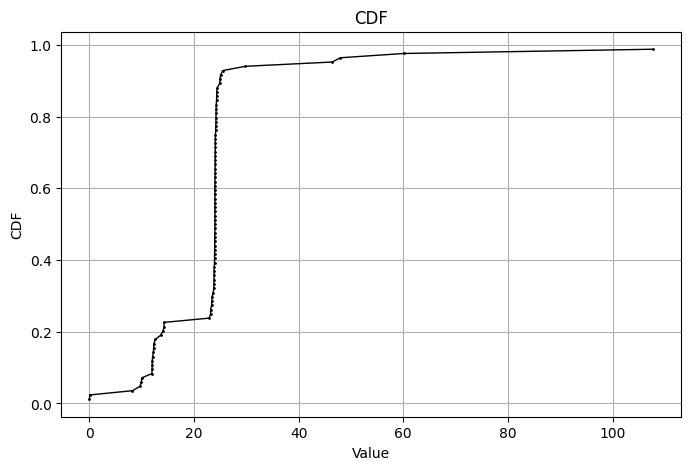

In [140]:
### Check on Basal median distance 
mdi_rows = facm.loc[(facm.FATEST=='BASAL INSULIN') & (facm.TRTMNT == 'MDI')]
basal_gaps = mdi_rows.groupby('USUBJID').FADTC.agg(lambda x: x.sort_values().diff().median())
basal_gaps = basal_gaps.dt.total_seconds()/3600
cdf.plot_cdf(basal_gaps)

#### Basal Flow Rate Modulation
Now we check if basal deliveries (U) modulate the basal delivery rates (U/hr). 
We know that there are some NaN flow rates and we will check if these could reflect 0 flow rates.

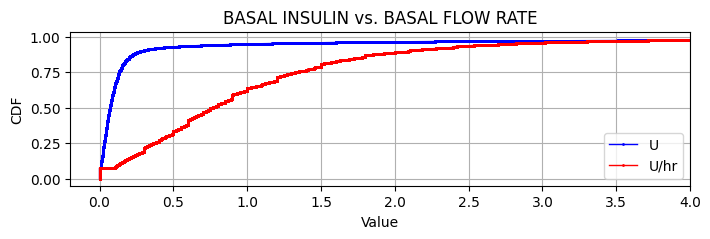

In [11]:
#what is the difference between basals in units and units/h, is there any diff?
plt.figure(figsize=(8,2));ax=plt.gca()
cdf.plot_cdf(facm.loc[facm.FATEST=='BASAL INSULIN'].FAORRES,ax=ax,color='blue',label='U')
cdf.plot_cdf(facm.loc[facm.FATEST=='BASAL FLOW RATE'].FAORRES,ax=ax,color='red',label='U/hr')
ax.set_xlim(-.2,4)
plt.title('BASAL INSULIN vs. BASAL FLOW RATE'); ax.legend()
plt.show()

We see that the deliveries are much smaller indicating that these are the actual deliveries.

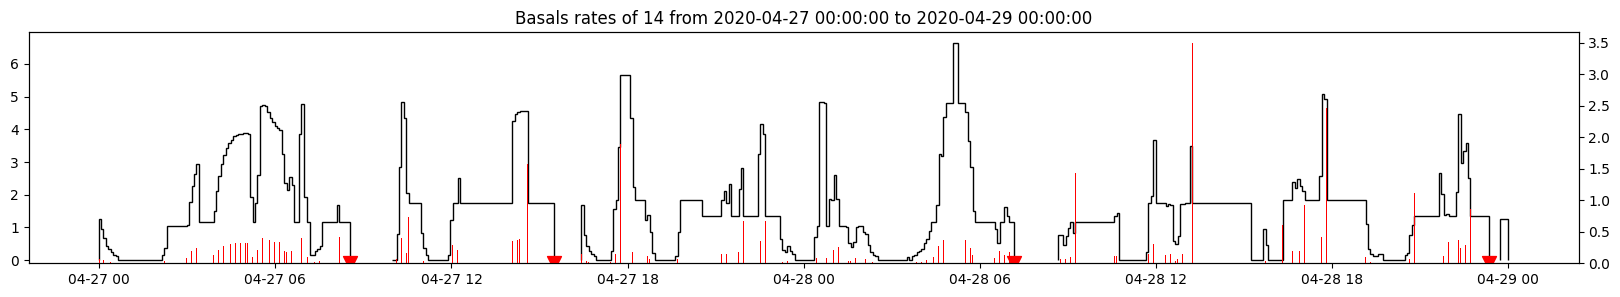

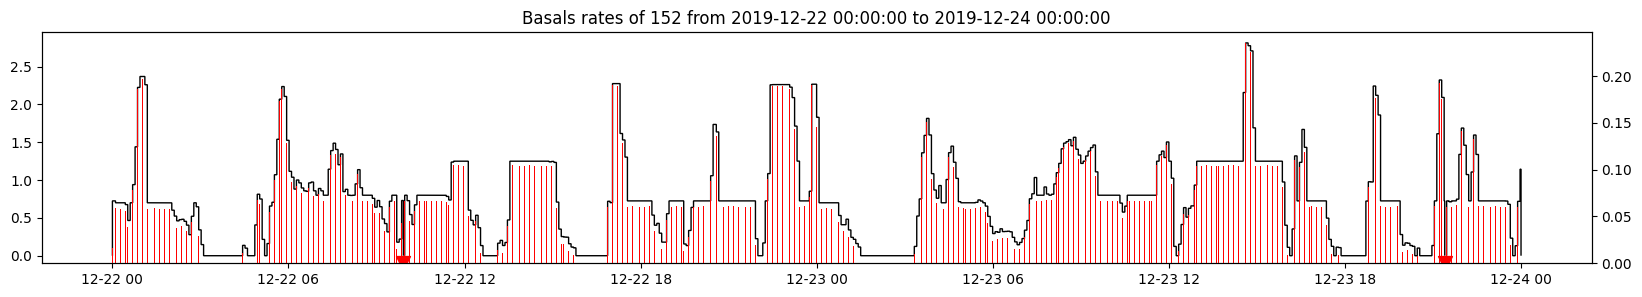

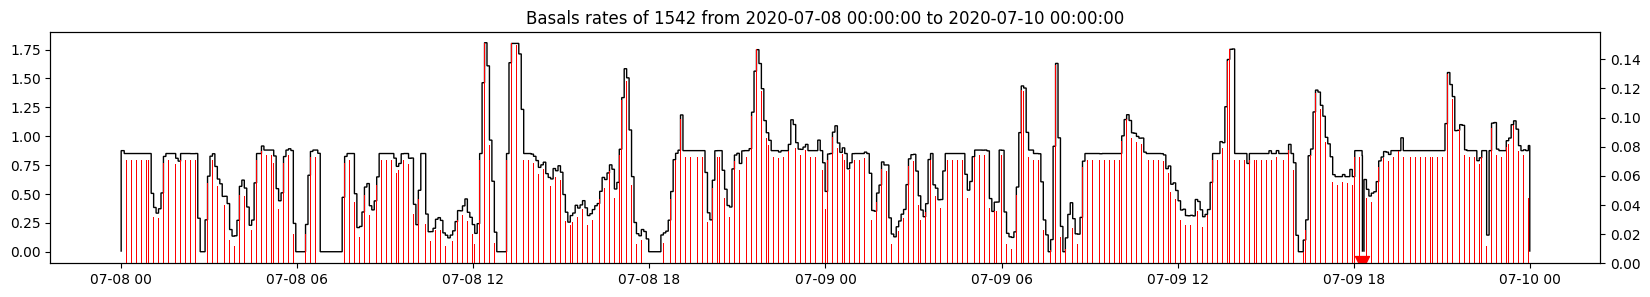

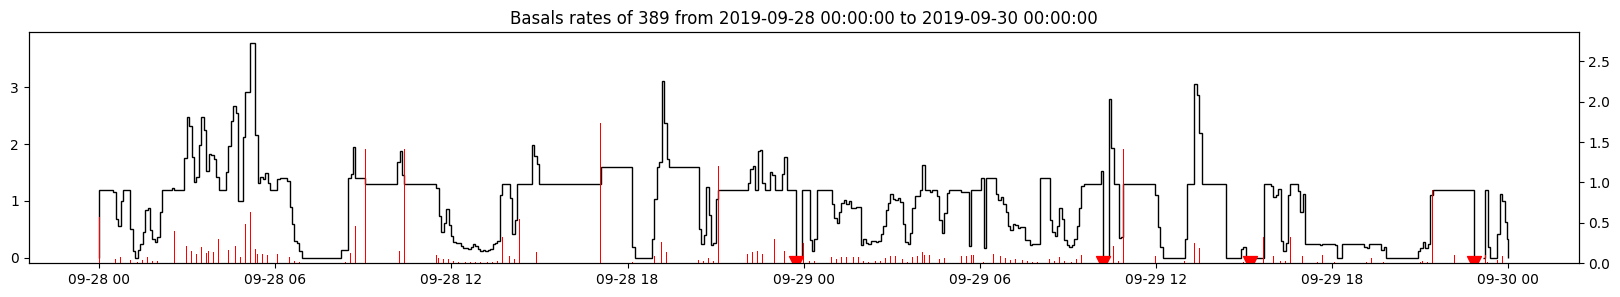

In [12]:
#plot examples for basal flow rates and basal deliveries for 
from src import drawing
from importlib import reload
reload(drawing)

#show an example of a flow rate and a basal within the same subject
#patient_id = np.random.choice(['1542', '1550','1286','389'])
patient_ids = facm.loc[~facm.DXTRT.isin(['MULTIPLE DAILY INJECTIONS'])].USUBJID.sample(2).values
for patient_id in ['14', '152','1542', '389']:

    sub = facm.loc[(facm.USUBJID==patient_id)&(facm.FATEST.notna())].sort_values('FADTC')
    start = sub.FADTC.min()+timedelta(days=1)
    dur = timedelta(hours=48)
    sub = sub.loc[(sub.FADTC>=start)&(sub.FADTC<=start+dur)]

    sub_flow_rates = sub.loc[sub.FATEST=='BASAL FLOW RATE']
    sub_basals = sub.loc[sub.FATEST=='BASAL INSULIN']
    
    #draw basal delivery rates
    plt.figure(figsize=(20,3)); ax=plt.gca()
    drawing.drawAbsoluteBasalRates(ax,sub_flow_rates.FADTC.values, sub_flow_rates.FAORRES.values,label='U/hr',hatch=None)
    
    #draw individual basal deliveries
    twinx = ax.twinx()
    drawing.drawBoluses(twinx,sub_basals.FADTC, sub_basals.FAORRES,label='U',width=timedelta(minutes=1))
    plt.title(f'Basals rates of {patient_id} from {start} to {start+dur}'); 
    
    # draw Nan deliveries as red xs at zero
    nan_flow_rates = sub_flow_rates.loc[sub_flow_rates.FAORRES.isna()]
    plt.scatter(nan_flow_rates.FADTC, [0]*len(nan_flow_rates), color='red', marker='v', s=100)
    
    # Set ylim to current limits but reduce minimum by 0.1
    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0] - 0.1, ylim[1])

    # Save the figure
    file = os.path.join(os.getcwd(),'..','..','docs','data_sets','assets','t1dexi_basal_and_flow_rates'+patient_id+'.png')
    plt.savefig(file)

Above we saw that the NaN values happen in regions where flow rates are 0. Let's look at a few examples.

In [13]:
#draw examples of rows surrounding nan basal deliveries
sample_nan_delivery_rates = facm.loc[(facm.FATEST=='BASAL FLOW RATE') & (facm.FAORRES.isna())].sample(1)

for row in sample_nan_delivery_rates.itertuples():
    sub = facm.loc[(facm.FATEST=='BASAL FLOW RATE') & (facm.USUBJID == row.USUBJID)].sort_values('FADTC')
    #use iloc to make sure we get the temporal neighbors
    i_loc = sub.index.get_loc(row.Index)
    display(sub.iloc[i_loc-1:i_loc+2])#[['FADTC','FADUR', 'FAORRES']])

,USUBJID,FATESTCD,FATEST,FAOBJ,FACAT,FAORRES,FAORRESU,FADTC,FADUR,INSDVSRC,INSSTYPE,INSNMBOL,INSEXBOL,day,DXTRT,TRTMNT
1439566,436,BASFLRT,BASAL FLOW RATE,INSULIN,BASAL,1.0,U/hr,2021-04-14 11:03:31,0 days 00:49:01,NaN,NaN,NaN,NaN,2021-04-14,TANDEM T:SLIM X2 WITH CONTROL IQ,AID
1439567,436,BASFLRT,BASAL FLOW RATE,INSULIN,BASAL,NaN,U/hr,2021-04-14 11:52:32,0 days 00:04:47,NaN,NaN,NaN,NaN,2021-04-14,TANDEM T:SLIM X2 WITH CONTROL IQ,AID
1439568,436,BASFLRT,BASAL FLOW RATE,INSULIN,BASAL,1.0,U/hr,2021-04-14 11:57:19,0 days 00:35:00,NaN,NaN,NaN,NaN,2021-04-14,TANDEM T:SLIM X2 WITH CONTROL IQ,AID


**Observations:**  
- The basal deliveries happen every 5 minutes and module the basal rate (U/hr) (at least in the example above).
- The NaN values happen in regions where flow rates are 0 and likely mark temporal suspensions.

So, are the delivery rates and individual deliveries equivalent?
  - We can check by calculating the sum (using U/hr and duration) and compare it to the sum obtained on all basal values (U)

##### Comparing basal flow rate and deliveries sums

In [14]:
#compare sums of total basal doses between deliveries and flow rates

pump_rows = facm.loc[~(facm.TRTMNT=='MDI')].copy()
pump_rows['day'] = pump_rows.FADTC.dt.date

# Check if for all Basal flow rates, there is a duration
print(f"For {100*pump_rows.loc[facm.FATEST=='BASAL FLOW RATE'].FADUR.notna().mean():.2f}% of flow rates (pump only) rows have a duration")

#calculate daily basal delivery as the product of duration and flow rate
flow_rates_with_dur = pump_rows.loc[pump_rows.FATEST=='BASAL FLOW RATE'].dropna(subset=['FADUR'])
pump_rows['basal_rate'] =  flow_rates_with_dur.FAORRES * flow_rates_with_dur.FADUR.dt.total_seconds()/3600
daily_flowrate_sums = pump_rows.groupby(['USUBJID','day'])['basal_rate'].sum(min_count=1)

#calculate daily basal delivery as the sum of all deliveries
daily_delivery_sums = pump_rows.loc[pump_rows.FATEST=='BASAL INSULIN'].groupby(['USUBJID','day'])['FAORRES'].sum(min_count=1)

#compare the daily deliveries
print(f'Total Daily Basal doses are {daily_flowrate_sums.sum():.2f}U (flow rates) {daily_delivery_sums.sum():.2f}U (deliveries)')
print(f"The error is:")
display((daily_flowrate_sums-daily_delivery_sums).agg(['mean','std','min','max','sum']))

For 100.00% of flow rates (pump only) rows have a duration
Total Daily Basal doses are 225438.32U (flow rates) 225464.24U (deliveries)
The error is:


mean    -0.002375
std      0.007214
min     -0.073941
max      0.074593
sum    -25.922100
dtype: float64

### ... summary
- Basal deliveries and flow rates are equivalent
- NaN flow rates likely mark 0 flow rates and should be replaced

### MDI vs. Pump Doses (NaN Basals Flows)
1. Check: Are BASAL FLOW RATES always zero in MDI? 
2. Check: Are BASAL in MDI much larger than in Pump?
3. Check: all BASAL in MDI injections?

In [15]:
#Where does the data sit in MDI
print("Which MDI columns contain valid values?")
# def isna(x):
#     return x.isna().sum()
r = facm.loc[facm.TRTMNT=='MDI'].groupby(['FATEST','FAORRESU'])[['FADTC','FADUR','INSSTYPE','INSNMBOL','INSEXBOL','FAORRES']].agg(['count'])
display(r)
del r


#Check how many BASAL FLOW RATES exists in MDI
mdi_with_flow_rates= facm.loc[(facm.TRTMNT=='MDI') &(facm.FATEST=='BASAL FLOW RATE')]
print(f'There are {len(mdi_with_flow_rates.USUBJID.unique())} MDI patients with flow rates')
print(f" wich are {100*len(mdi_with_flow_rates)/len(facm.loc[(facm.DXTRT=='MULTIPLE DAILY INJECTIONS')]):.2f}% of the MDI data")
print(f" from these, {mdi_with_flow_rates.FAORRES.count()} are not NaN")


Which MDI columns contain valid values?


,,FADTC,FADUR,INSSTYPE,INSNMBOL,INSEXBOL,FAORRES
,,count,count,count,count,count,count
FATEST,FAORRESU,,,,,,
BASAL FLOW RATE,U/hr,2365,0,0,0,0,0
BASAL INSULIN,U,2365,0,0,0,0,2365
BOLUS INSULIN,U,9515,0,0,0,0,9515


There are 84 MDI patients with flow rates
 wich are 16.60% of the MDI data
 from these, 0 are not NaN


#### MDI Basal Durations
We know that Flow rates are incorrect. So probably, the delivery durations are also not correctly set.

In [16]:
#temp = facm
temp = facm.loc[facm.FATEST.isin(['BASAL FLOW RATE','BASAL INSULIN'])]
temp.groupby('DXTRT').FADUR.agg(lambda x: x.isna().sum())

DXTRT
INSULET OMNIPOD DASH                            0
INSULET OMNIPOD INSULIN MANAGEMENT SYSTEM       2
MEDTRONIC 551 (530G)                            0
MEDTRONIC 630G                                  0
MEDTRONIC 640G                                  0
MEDTRONIC 670G                                  0
MEDTRONIC 670G IN AUTO MODE                     0
MEDTRONIC 670G IN MANUAL MODE                   0
MEDTRONIC 751 (530G)                            0
MEDTRONIC 770G                                  0
MEDTRONIC 770G IN AUTO MODE                     0
MEDTRONIC PARADIGM 522                          0
MEDTRONIC PARADIGM 523 (REVEL)                  0
MEDTRONIC PARADIGM 723 (REVEL)                  0
MULTIPLE DAILY INJECTIONS                    4730
TANDEM T:SLIM                                   0
TANDEM T:SLIM X2                                0
TANDEM T:SLIM X2 WITH BASAL IQ                  0
TANDEM T:SLIM X2 WITH CONTROL IQ                0
Name: FADUR, dtype: int64

In [17]:
facm.loc[facm.FATEST.isin(['BASAL INSULIN']) & (facm.DXTRT=='MULTIPLE DAILY INJECTIONS')].FADUR.value_counts(dropna=False)

FADUR
NaT    2365
Name: count, dtype: int64

#### MDI Basal durations? How often do patients inject?

(-10.0, 200.0)

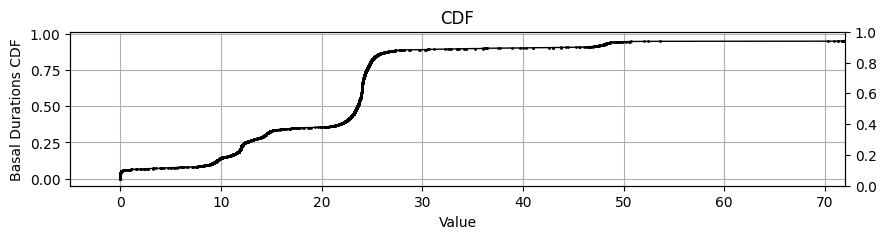

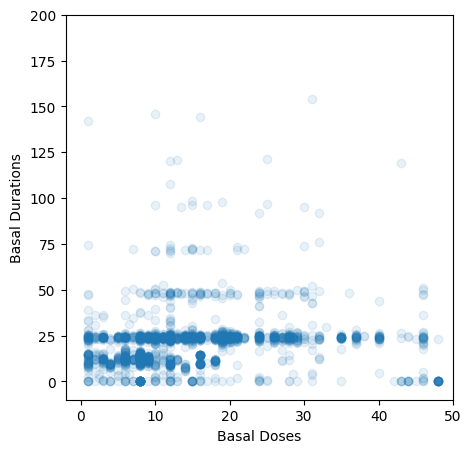

In [18]:
mdi_basal = facm.loc[facm.FATEST.isin(['BASAL INSULIN']) & (facm.DXTRT=='MULTIPLE DAILY INJECTIONS')]

basal_dur = mdi_basal.groupby('USUBJID').FADTC.apply(lambda x: x.diff().dt.total_seconds()/3600)
plt.figure(figsize=(10,2));ax=plt.gca(); twinx = ax.twinx()
cdf.plot_cdf(basal_dur, label='MDI Basal Durations',ax=ax);
ax.set_ylabel('Basal Durations CDF')
ax.set_xlim(-5,72)
save = os.path.join(os.getcwd(),'..','..','docs','data_sets','assets','t1dexi_mdi_basal_durations.png')
plt.savefig(save)

#cdf.plot_cdf(mdi_basal.FAORRES, label='MDI Basal Doses',ax=twinx,color='red')
#twinx.set_ylabel('Basal Doses CDF')

plt.figure(figsize=(5,5));ax=plt.gca()
ax.scatter(mdi_basal.FAORRES, basal_dur, alpha=0.1)
ax.set_xlabel('Basal Doses'); ax.set_ylabel('Basal Durations'); ax.set_xlim(-2,50); ax.set_ylim(-10,200)

As we can see there are several groups:
 1. around 0 hours (could be priming doses)
 2. <102h (half day insulin like levimir)
 3. around 24h (1 time injections like glargine)
 4. some around 48 hours (degludec) and possibly missed doses 

 This seems reasonable. While we might miss some doses (either no injection happened or not logged), this seems to be a fair approximation. Further investigation could be done to correlate these fundings based on the basal insulin type.

In [19]:
mdi_basal = mdi_basal.sort_values('FADTC')
mdi_basal['FADUR'] = mdi_basal.groupby('USUBJID',group_keys=False).FADTC.apply(lambda x: x.sort_values().diff().shift(-1))
mdi_basal.groupby('USUBJID').apply(lambda x: x.sort_values('FADTC').FADUR.iloc[-1])
#the last one should be NaT

/var/folders/m4/5d02b2xs0l52lbxzbk0t3vym0000gp/T/ipykernel_67081/3292699570.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mdi_basal.groupby('USUBJID').apply(lambda x: x.sort_values('FADTC').FADUR.iloc[-1])


USUBJID
1      NaT
1015   NaT
103    NaT
110    NaT
1115   NaT
        ..
920    NaT
932    NaT
979    NaT
981    NaT
987    NaT
Length: 84, dtype: datetime64[ns]

In [20]:
import pandas as pd

# Create a sample DataFrame
data = pd.DataFrame({
    'USUBJID': ['1', '1', '1', '2', '2', '2','3'],
    'FADTC': [2, 1, 5, 5, 2, 1, 3],
    'FADUR': [1, 1, 1, 1,1,1,1]  # New column to assign values
})

# Subset the DataFrame
subset = data[data['USUBJID'] == '2']

# Calculate a new column for the subset
subset['FADUR'] = subset['FADTC'].diff().shift(-1)
display(subset['FADUR'])
# Assign the calculated values back to the original DataFrame
data.loc[subset.index,'FADUR'] = subset.FADUR
#data.loc[subset.index, 'FADUR'] = subset['FADUR']

print(data)

/var/folders/m4/5d02b2xs0l52lbxzbk0t3vym0000gp/T/ipykernel_67081/3018452965.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['FADUR'] = subset['FADTC'].diff().shift(-1)


3   -3.0
4   -1.0
5    NaN
Name: FADUR, dtype: float64

  USUBJID  FADTC  FADUR
0       1      2    1.0
1       1      1    1.0
2       1      5    1.0
3       2      5   -3.0
4       2      2   -1.0
5       2      1    NaN
6       3      3    1.0


In [23]:
#show examples for priming doses or duplicated injections

#select a basal with short duration
mdi_basal = mdi_basal.sort_values('FADTC')
sample = mdi_basal.loc[mdi_basal.FADUR<timedelta(hours=1)].sample()
user = sample.USUBJID.values[0]
index = sample.index.values[0]

#show the row and the next one for that patient
temp = mdi_basal.loc[mdi_basal.USUBJID==user]
i = temp.index.get_loc(index)
display(temp.iloc[i:i+2])

,USUBJID,FATESTCD,FATEST,FAOBJ,FACAT,FAORRES,FAORRESU,FADTC,FADUR,INSDVSRC,INSSTYPE,INSNMBOL,INSEXBOL,day,DXTRT,TRTMNT
1110039,174,INSBASAL,BASAL INSULIN,INSULIN,BASAL,1.0,U,2020-05-14 05:25:53,0 days 00:00:40,Injections,NaN,NaN,NaN,2020-05-14,MULTIPLE DAILY INJECTIONS,MDI
1110040,174,INSBASAL,BASAL INSULIN,INSULIN,BASAL,8.0,U,2020-05-14 05:26:33,0 days 08:10:15,Injections,NaN,NaN,NaN,2020-05-14,MULTIPLE DAILY INJECTIONS,MDI


**Observation**: 
- All flow rates in MDI are NaN
- All Basal insulin durations are NaN
- It is unclear where these come from
- Values in all other insulin relevant columns are also NaN
- there are priming doses and double injections

Assumption: We can probably drop the FLOW rates for MDI.


Let's check if the total bolus and basal doses match are similar between pump and mdi users 

#### MDI vs. Pump Doses

In [24]:
#calculate average total daily bolus and basal dose per group

facm['day'] = facm.FADTC.dt.date

#sum per FATEST type
#remove BASAL FLOW RATES from the dataset assuming that they reflect the same as the sum of BASAL INSULIN deliveries for Pump users (they are Nan for MDI any way)
temp = facm.loc[facm.FATEST!='BASAL FLOW RATE']
r = temp.groupby(['TRTMNT','FATEST','USUBJID','day'])[['FAORRES']].agg('sum')
#bolus, basal per day
#display(r.sample(3))

#sum per day
daily_sum = r.sum(axis=1)
#display(daily_sum.sample(3))

#mean basal/bolus
group_mean = daily_sum.groupby(level=[0, 1]).mean()
display(group_mean)

TRTMNT  FATEST       
AID     BASAL INSULIN    20.642522
        BOLUS INSULIN    21.650365
CSII    BASAL INSULIN    20.660760
        BOLUS INSULIN    18.455363
MDI     BASAL INSULIN    19.176018
        BOLUS INSULIN    18.187278
dtype: float64

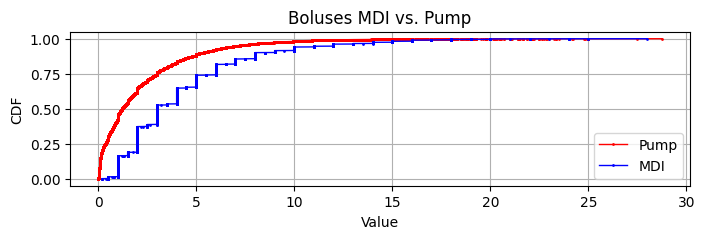

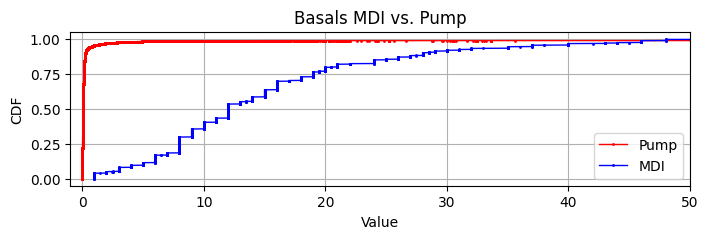

In [25]:
#let's compare the dose sizes
daily_sum_patient = daily_sum.groupby(level=[0,1,2]).mean()
plt.figure(figsize=(8,2)); ax=plt.gca()
cdf.plot_cdf(facm.loc[(~(facm.TRTMNT=='MDI'))&(facm.FATEST=='BOLUS INSULIN')].FAORRES,ax=ax,label='Pump',color='red')
cdf.plot_cdf(facm.loc[((facm.TRTMNT=='MDI'))&(facm.FATEST=='BOLUS INSULIN')].FAORRES,ax=ax,label='MDI',color='blue')

file = os.path.join(os.getcwd(),'..','..','docs','data_sets','assets','t1dexi_mdi_vs_pump_bolus_doses.png')
plt.savefig(file)


ax.legend(); ax.set_title('Boluses MDI vs. Pump')
plt.figure(figsize=(8,2)); ax=plt.gca()
cdf.plot_cdf(facm.loc[(~(facm.TRTMNT=='MDI'))&(facm.FATEST=='BASAL INSULIN')].FAORRES,ax=ax,label='Pump',color='red')
cdf.plot_cdf(facm.loc[(facm.TRTMNT=='MDI')&(facm.FATEST=='BASAL INSULIN')].FAORRES,ax=ax,label='MDI',color='blue')
ax.legend(); ax.set_title('Basals MDI vs. Pump');ax.set_xlim(-1,50)

file = os.path.join(os.getcwd(),'..','..','docs','data_sets','assets','t1dexi_mdi_vs_pump_basal_doses.png')
plt.savefig(file)


### ... summary
- All BASAL in MDI are of much larger value (indicating injections)

In [26]:
#drop MDI flow rates
facm = facm.loc[~ ((facm.FATEST=='BASAL FLOW RATE') & (facm.DXTRT=='MULTIPLE DAILY INJECTIONS'))]

### Bolus Columns

We know that insulin boluses can end up in FAORRES but also in INSNMBOL (normal boluses) and INSEXBOL (extended boluses).

The expectation is that FAORRES carries the sum of the INMBOL and INSEXBOL.  
Can we rely on this or do some boluses not end up in here?

In [27]:
#How many of the 3 columns INSEXBOL INSNMBOL FAORRES carry values?
print('Number of values with values in more than one of the columns INSEXBOL, INSNMBOL, FAORRES')

bolus_rows = facm.loc[(facm.FATEST=='BOLUS INSULIN')]
print('\nPUMP:')
display(bolus_rows[['INSEXBOL','INSNMBOL','FAORRES']].notna().sum(axis=1).value_counts().sort_index())

print('\nMDI:')
display(bolus_rows[['INSEXBOL','INSNMBOL','FAORRES']].notna().sum(axis=1).value_counts().sort_index())

Number of values with values in more than one of the columns INSEXBOL, INSNMBOL, FAORRES

PUMP:


1    29463
2    80626
3     2633
Name: count, dtype: int64


MDI:


1    29463
2    80626
3     2633
Name: count, dtype: int64

We see that for pump values, we often have only 1 value. So the assumption that FAORRESS is the sum of the other two must be wrong or at least there are exceptions.

In [28]:
#check for Rows with only 1 value
for num_vals in [1,2,3]:
    temp = bolus_rows.loc[bolus_rows[['INSEXBOL','INSNMBOL','FAORRES']].notna().sum(axis=1) == num_vals]
    print(f'{100*len(temp)/len(bolus_rows):.2f}% of rows have {num_vals} columns with values')
    display(temp[['INSEXBOL','INSNMBOL','FAORRES']].count())

26.14% of rows have 1 columns with values


INSEXBOL        0
INSNMBOL        0
FAORRES     29463
dtype: int64

71.53% of rows have 2 columns with values


INSEXBOL      350
INSNMBOL    80276
FAORRES     80626
dtype: int64

2.34% of rows have 3 columns with values


INSEXBOL    2633
INSNMBOL    2633
FAORRES     2633
dtype: int64

Let's check if there is a difference in insulin types between these cases

In [29]:
#check breakdown of source and insulin types
for num_vals in [1,2,3]:
    print(f'\n\nRows with {num_vals} columns carrying values: ..')
    temp = bolus_rows.loc[bolus_rows[['INSEXBOL','INSNMBOL','FAORRES']].notna().sum(axis=1) == num_vals]
    #display(temp.FATEST.value_counts())
    display(temp.value_counts(['FATEST','INSDVSRC','INSSTYPE'],dropna=False,sort=False))



Rows with 1 columns carrying values: ..


FATEST         INSDVSRC    INSSTYPE                  
BOLUS INSULIN  Injections  NaN                            9516
               Pump        automatic bolus/correction       26
                           combination                      46
                           dual (normal part)                1
                           dual (square part)                1
                           normal                        19799
                           square                            1
                           standard                         27
                           standard/correction              46
Name: count, dtype: int64



Rows with 2 columns carrying values: ..


FATEST         INSDVSRC  INSSTYPE 
BOLUS INSULIN  Pump      automated     1619
                         normal       78657
                         square         350
Name: count, dtype: int64



Rows with 3 columns carrying values: ..


FATEST         INSDVSRC  INSSTYPE   
BOLUS INSULIN  Pump      combination       2
                         dual/square    2631
Name: count, dtype: int64

Not clear, now let's check if at least the sums match up.

In [30]:
#Let's check if the sums match if there is at least one other value in the other columns
temp = bolus_rows.loc[bolus_rows[['INSEXBOL','INSNMBOL','FAORRES']].notna().sum(axis=1) > 1].copy()
temp = temp[['INSEXBOL','INSNMBOL','FAORRES']].fillna(0) # this makes sure the sum does not result in NaN if only ISNMBOL or INSEXBOL has a value
r = temp.FAORRES - (temp.INSEXBOL+temp.INSNMBOL)
print(r.agg(['count','mean','std','min','max','sum']))

count    8.325900e+04
mean     7.214836e-07
std      1.192128e-04
min     -4.900000e-04
max      5.000000e-04
sum      6.007000e-02
dtype: float64


Yes, they match exactly. 
Last thought: could the rows that have only values in FAORRES be duplicated reports?

In [31]:
#check if there are any boluses reported multiple times. Since we know that FAORRESS always contians the sum, we need to check for duplicates on that column
print(f"{bolus_rows.duplicated(subset=['USUBJID','FADTC','FAORRES']).sum()} duplicated boluses")

0 duplicated boluses


In [32]:
#check if for those rows with only a value in FAORRES the duration is always NaN
temp = bolus_rows.loc[bolus_rows[['INSEXBOL','INSNMBOL']].notna().sum(axis=1) ==0]
temp[['FAORRES','INSEXBOL','INSNMBOL','FADUR']].count()

FAORRES     29463
INSEXBOL        0
INSNMBOL        0
FADUR           0
dtype: int64

### ... summary
- faorres always contains a value (total dose)
- often these are split into the other two columns INSEXBOL or INSMBOL however not always!
-  Many boluses don't end up in the INMBOL and INSEXBOL columns
  - then only FAORRES contains a value
  - the duration for these boluses is always Nan
  - close to 100% are normal boluses (based on instype) 
    - (only 2 square part and 46 combination whatever those are)
- There are no duplicated boluses

In [33]:
#assign FAORRES values to INSNMBOL if there are no values in INSMBOL and INSEXBOL
facm.loc[(facm.FATEST=='BOLUS INSULIN') & facm[['INSEXBOL','INSNMBOL']].isna().all(axis=1),'INSMNBL'] = facm.FAORRES

## Open Questions to answer
Baed on the script analysis, we found more inconsistencies that we need to check before moving forward.

- Are there difference between FATEST and FACAT
- Are there differences between the pumps and which column conditions to use?
- Which subjects and dates are being removed and why?
- Basal Overlaps: How should we deal with them?
- Are there differences between pumps?
- How should suspends be treated?

### FASTEST vs. FACAT?
We see that sometimes, FATEST and sometimes FACAT are used to to identify BASAL or BOLUS: 
  - Are there difference between FATEST and FACAT

In the script the cunking procedure filters boluses using FACAT for 670G and Tandem: `(main_df['FACAT'] == 'BOLUS')`
In our previous analysis *Inspect Column Hierachy* we've already seen that FACAT and FATEST are perfectly aligned.
Let's check again if we would get the same rows:

In [34]:
#print value counts
facm.value_counts(subset=['FACAT','FATEST'],dropna=False)

FACAT  FATEST         
BASAL  BASAL INSULIN      1053400
       BASAL FLOW RATE    1051035
BOLUS  BOLUS INSULIN       112722
Name: count, dtype: int64

FACAT is high level for FATEST.

### ... Summary:

FATEST and FACAT are consistent. For simplicity purposes we should only use one even if we have to select BASAL INSULIN and BASAL FLOW RATES. However, we will only use BASAL FLOW RATES anyway.

### Pump Column Rules?
We see that there are different rules used between 670G and Tandem vs. 770G to select basal and boluses. Are there differences between the pumps and which column conditions to use?

Example from the netiob script (here code from the cunking method) showing differences in selecting basal based on pump type

**Tandem and 670G basal:** ```(main_df['FATEST'] == 'BASAL INSULIN') & (main_df['INSSTYPE'].isin(['scheduled', 'suspend', 'temp', 'automated']))```
**770G basal:** ```(main_df['FATEST'] == 'BASAL INSULIN')```

In [35]:
#check if FATEST==BASAL INSULIN gives the same rows as FATEST==BASAL INSULIN & main_df['INSSTYPE'].isin(['scheduled', 'suspend', 'temp', 'automated'])
sub1 = facm.loc[(facm.FATEST=='BASAL INSULIN')]
sub2 = facm.loc[(facm.FATEST=='BASAL INSULIN') & (facm.INSSTYPE.isin(['scheduled', 'suspend', 'temp', 'automated']))]

if sub1.equals(sub2):
    print('FATEST==BOLUS INSULIN is the same as FATEST==BOLUS INSULIN & main_df[INSSTYPE].isin([scheduled, suspend, temp, automated])')
else:
    print('FATEST==BOLUS INSULIN is NOT the same as FATEST==BOLUS INSULIN & main_df[INSSTYPE].isin([scheduled, suspend, temp, automated])')

excluded = sub1.loc[~sub1.index.isin(sub2.index)]
print(f"There are {len(excluded)} more rows when only looking at BASAL INSULIN")
print(f'The excluded rows amount to {excluded.FAORRES.sum()}U or {excluded.FAORRES.sum()/sub1.FAORRES.sum()*100:.2f}% of the total basal insulin')

#examples
print("Some example rows:")
display(excluded.head(4))

#INSTYPE value counts
print('INSSTYPEs: ')
display(excluded.value_counts(subset=['INSSTYPE'],dropna=False))

#basal dose sum by device
print('Sum of "missed" basal insulin by device')
excluded.groupby(['DXTRT'])['FAORRES'].sum().sort_values(ascending=False)

FATEST==BOLUS INSULIN is NOT the same as FATEST==BOLUS INSULIN & main_df[INSSTYPE].isin([scheduled, suspend, temp, automated])
There are 5176 more rows when only looking at BASAL INSULIN
The excluded rows amount to 43155.545U or 16.54% of the total basal insulin
Some example rows:


,USUBJID,FATESTCD,FATEST,FAOBJ,FACAT,FAORRES,FAORRESU,FADTC,FADUR,INSDVSRC,INSSTYPE,INSNMBOL,INSEXBOL,day,DXTRT,TRTMNT,INSMNBL
29,1,INSBASAL,BASAL INSULIN,INSULIN,BASAL,28.0,U,2020-05-11 23:12:21,NaT,Injections,NaN,NaN,NaN,2020-05-11,MULTIPLE DAILY INJECTIONS,MDI,NaN
30,1,INSBASAL,BASAL INSULIN,INSULIN,BASAL,1.0,U,2020-05-12 07:09:22,NaT,Injections,NaN,NaN,NaN,2020-05-12,MULTIPLE DAILY INJECTIONS,MDI,NaN
31,1,INSBASAL,BASAL INSULIN,INSULIN,BASAL,1.0,U,2020-05-13 08:35:47,NaT,Injections,NaN,NaN,NaN,2020-05-13,MULTIPLE DAILY INJECTIONS,MDI,NaN
32,1,INSBASAL,BASAL INSULIN,INSULIN,BASAL,1.0,U,2020-05-14 06:50:24,NaT,Injections,NaN,NaN,NaN,2020-05-14,MULTIPLE DAILY INJECTIONS,MDI,NaN


INSSTYPEs: 


INSSTYPE
NaN         5176
Name: count, dtype: int64

Sum of "missed" basal insulin by device


DXTRT
MULTIPLE DAILY INJECTIONS                    35398.930
INSULET OMNIPOD INSULIN MANAGEMENT SYSTEM     3540.258
MEDTRONIC 770G IN AUTO MODE                   1532.443
MEDTRONIC 670G IN MANUAL MODE                 1219.853
MEDTRONIC 770G                                 926.055
MEDTRONIC 670G IN AUTO MODE                    467.797
TANDEM T:SLIM X2 WITH BASAL IQ                  70.209
Name: FAORRES, dtype: float64

In [36]:
#show surrounding rows of NaN insulin type basal
#this analysis assumes sorted by user and time
#facm = facm.sort_values(['USUBJID','FADTC'])
sample = excluded.sample(1)
display(sample)
iloc = facm.index.get_loc(sample.index[0])
facm.iloc[iloc-2:iloc+3]

,USUBJID,FATESTCD,FATEST,FAOBJ,FACAT,FAORRES,FAORRESU,FADTC,FADUR,INSDVSRC,INSSTYPE,INSNMBOL,INSEXBOL,day,DXTRT,TRTMNT,INSMNBL
2054401,862,INSBASAL,BASAL INSULIN,INSULIN,BASAL,7.747,U,2020-10-02 20:07:36,0 days 03:52:24,Pump,NaN,NaN,NaN,2020-10-02,MEDTRONIC 670G IN MANUAL MODE,CSII,NaN


,USUBJID,FATESTCD,FATEST,FAOBJ,FACAT,FAORRES,FAORRESU,FADTC,FADUR,INSDVSRC,INSSTYPE,INSNMBOL,INSEXBOL,day,DXTRT,TRTMNT,INSMNBL
2054399,862,INSBASAL,BASAL INSULIN,INSULIN,BASAL,0.000,U,2020-10-02 20:07:21,0 days 00:00:00,Pump,NaN,NaN,NaN,2020-10-02,MEDTRONIC 670G IN MANUAL MODE,CSII,NaN
2054400,862,INSBASAL,BASAL INSULIN,INSULIN,BASAL,0.000,U,2020-10-02 20:07:21,0 days 00:00:15,Pump,NaN,NaN,NaN,2020-10-02,MEDTRONIC 670G IN MANUAL MODE,CSII,NaN
2054401,862,INSBASAL,BASAL INSULIN,INSULIN,BASAL,7.747,U,2020-10-02 20:07:36,0 days 03:52:24,Pump,NaN,NaN,NaN,2020-10-02,MEDTRONIC 670G IN MANUAL MODE,CSII,NaN
2054402,862,INSBASAL,BASAL INSULIN,INSULIN,BASAL,0.000,U,2020-10-03 00:00:00,0 days 00:00:00,Pump,NaN,NaN,NaN,2020-10-03,MEDTRONIC 670G IN MANUAL MODE,CSII,NaN
2054403,862,INSBASAL,BASAL INSULIN,INSULIN,BASAL,3.200,U,2020-10-03 00:00:00,0 days 02:00:00,Pump,NaN,NaN,NaN,2020-10-03,MEDTRONIC 670G IN MANUAL MODE,CSII,NaN


(-1.0, 50.0)

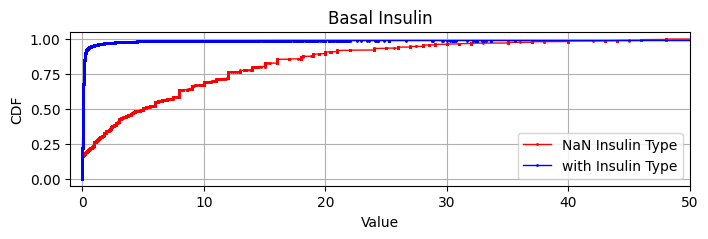

In [37]:
#compare distriubtion of basal insulin with/without subtype
plt.figure(figsize=(8,2)); ax=plt.gca()
cdf.plot_cdf(excluded.FAORRES,ax=ax,label='NaN Insulin Type',color='red')
cdf.plot_cdf(sub2.FAORRES,ax=ax,label='with Insulin Type',color='blue')
plt.title('Basal Insulin'); plt.legend();plt.xlim(-1,50)

### ... Summary:
 - There are rows with INSTYPE == NaN which would have been excludede in the netiob script.
 - >16% of all basal insulin would have been missed
 - Of those, most are MDI
 - The distribution confirms that these are mostly bigger mdi injections
 - The examples don't give reason to believe that they should be excluded (e.g. no duplicates)

 Conclusion: It appears that NaN Insulin Types should be includede (no filtering based on insulin type)

### Basal Overlaps
4. Basal Overlaps: We see that basal overlaps are removed. 
  - How do they remove basal overlaps? 
  - Why do these occur at all?
  - How often do they occur?

In [68]:
#identify overlapping basal flow rates (here, we check only if one of the two next rows overlap)

def overlaps(df):
    assert df.FADTC.is_monotonic_increasing
    end = df.FADTC + df.FADUR  
    next = df.FADTC.shift(-1)
    overlap = (next < end)
    return overlap

flow_rows = facm.loc[facm.FATEST=='BASAL FLOW RATE'].copy()
flow_rows['overlaps'] = flow_rows.groupby('USUBJID').apply(overlaps, include_groups=False).droplevel(0)
#flow_rows['END'] = flow_rows.FADTC + flow_rows.FADUR

print(f'{flow_rows.overlaps.sum()} overlapping basal flow rates')
#how often does it happen?
print(f'{flow_rows.overlaps.mean()*100:.2f}% the next flow rate starts before the previous ends')
#which pumps are affected?
flow_rows.loc[flow_rows.overlaps].DXTRT.value_counts()

721 overlapping basal flow rates
0.07% the next flow rate starts before the previous ends


DXTRT
INSULET OMNIPOD INSULIN MANAGEMENT SYSTEM    340
TANDEM T:SLIM X2 WITH CONTROL IQ             264
MEDTRONIC 670G IN AUTO MODE                   87
MEDTRONIC 670G IN MANUAL MODE                 19
TANDEM T:SLIM X2 WITH BASAL IQ                 8
MEDTRONIC PARADIGM 723 (REVEL)                 2
MEDTRONIC 630G                                 1
Name: count, dtype: int64

In [69]:
#show examples
def display_neighboring_rows_of_row(df, row,iprev,inext):
    iloc = df.index.get_loc(row.Index)
    display(df.iloc[iloc-iprev:iloc+inext+1])

sample = flow_rows.loc[flow_rows.overlaps].sample(1)

for row in sample.itertuples():
    display_neighboring_rows_of_row(flow_rows[['USUBJID','FATEST','FAORRES','FADTC','FADUR']], row, 0,2)

,USUBJID,FATEST,FAORRES,FADTC,FADUR
1996750,830,BASAL FLOW RATE,0.815,2019-10-08 03:14:46,0 days 00:04:59
1996751,830,BASAL FLOW RATE,0.317,2019-10-08 03:15:44,0 days 00:05:00
1996752,830,BASAL FLOW RATE,1.832,2019-10-08 03:19:45,0 days 00:09:58


In [70]:
#Example for a patient with Omnipod and overlapping basal flow rates
#Here we see that relying on the BASAL INSULIN would be wrong because the duration is not correct
#instead, we need to take the flow rate and modify the duration until the next flow rate starts
facm.loc[(facm.USUBJID=='1722') & (facm.FADTC.dt.date == datetime(2020, 10, 1).date()) & (facm.FACAT=='BASAL')].sort_values('FADTC').iloc[8:12]

,USUBJID,FATESTCD,FATEST,FAOBJ,FACAT,FAORRES,FAORRESU,FADTC,FADUR,INSDVSRC,INSSTYPE,INSNMBOL,INSEXBOL,day,DXTRT,TRTMNT,INSMNBL
1108778,1722,BASFLRT,BASAL FLOW RATE,INSULIN,BASAL,1.100,U/hr,2020-10-01 05:02:57,0 days 10:00:00,NaN,NaN,NaN,NaN,2020-10-01,INSULET OMNIPOD INSULIN MANAGEMENT SYSTEM,CSII,NaN
1109021,1722,INSBASAL,BASAL INSULIN,INSULIN,BASAL,11.000,U,2020-10-01 05:02:57,0 days 10:00:00,Pump,scheduled,NaN,NaN,2020-10-01,INSULET OMNIPOD INSULIN MANAGEMENT SYSTEM,CSII,NaN
1108779,1722,BASFLRT,BASAL FLOW RATE,INSULIN,BASAL,1.000,U/hr,2020-10-01 15:00:00,0 days 01:45:32,NaN,NaN,NaN,NaN,2020-10-01,INSULET OMNIPOD INSULIN MANAGEMENT SYSTEM,CSII,NaN
1109022,1722,INSBASAL,BASAL INSULIN,INSULIN,BASAL,1.759,U,2020-10-01 15:00:00,0 days 01:45:32,Pump,scheduled,NaN,NaN,2020-10-01,INSULET OMNIPOD INSULIN MANAGEMENT SYSTEM,CSII,NaN


In [71]:
## correct for overlaps
def correct_overlap(df):
    fadur_corr = df.FADUR
    fadur_corr[df.overlaps] = df.FADTC.diff().shift(-1)[df.overlaps]
    return fadur_corr
flow_rows['FADUR_CORR'] = flow_rows.groupby('USUBJID', group_keys=False).apply(correct_overlap)
flow_rows[['USUBJID','FATEST','FAORRES','FADTC','FADUR','FADUR_CORR']]
flow_rows[flow_rows.overlaps][['USUBJID','FATEST','FAORRES','FADTC','FADUR','FADUR_CORR']]

print(flow_rows.overlaps.sum())
print((flow_rows.FADUR!=flow_rows.FADUR_CORR).sum())

/var/folders/m4/5d02b2xs0l52lbxzbk0t3vym0000gp/T/ipykernel_67081/64706985.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  flow_rows['FADUR_CORR'] = flow_rows.groupby('USUBJID', group_keys=False).apply(correct_overlap)


,USUBJID,FATEST,FAORRES,FADTC,FADUR,FADUR_CORR
313,1000,BASAL FLOW RATE,1.1000,2020-10-13 21:00:00,0 days 03:00:00,0 days 02:00:00
110609,1072,BASAL FLOW RATE,0.9500,2021-01-26 07:00:00,0 days 01:00:00,0 days 00:57:40
110612,1072,BASAL FLOW RATE,0.9425,2021-01-26 08:00:00,0 days 01:00:00,0 days 00:00:00
120251,1077,BASAL FLOW RATE,0.9500,2019-12-21 14:31:11,0 days 00:04:59,0 days 00:03:47
120252,1077,BASAL FLOW RATE,0.1790,2019-12-21 14:34:58,0 days 00:05:00,0 days 00:01:12
...,...,...,...,...,...,...
2127061,933,BASAL FLOW RATE,0.3000,2020-10-14 03:39:31,0 days 03:30:00,0 days 03:20:29
2127062,933,BASAL FLOW RATE,0.5500,2020-10-14 07:00:00,0 days 13:30:00,0 days 00:09:31
2127063,933,BASAL FLOW RATE,0.5500,2020-10-14 07:09:31,0 days 13:30:00,0 days 13:20:29
2127064,933,BASAL FLOW RATE,0.4500,2020-10-14 20:30:00,0 days 03:30:00,0 days 00:09:31


In [72]:
#show examples of corrected row
sample = flow_rows.loc[flow_rows.overlaps].sample(1)
for row in sample.itertuples():
    display_neighboring_rows_of_row(flow_rows[['USUBJID','FATEST','FAORRES','FADTC','FADUR','FADUR_CORR']], row, 0,2)

,USUBJID,FATEST,FAORRES,FADTC,FADUR,FADUR_CORR
2126962,933,BASAL FLOW RATE,0.45,2020-10-04 20:30:00,0 days 03:30:00,0 days 00:04:40
2126963,933,BASAL FLOW RATE,0.45,2020-10-04 20:34:40,0 days 03:25:20,0 days 00:09:32
2126964,933,BASAL FLOW RATE,0.45,2020-10-04 20:44:12,0 days 03:15:48,0 days 00:03:52


In [74]:
#check number of overlaps after correction
flow_rows['FADUR']=flow_rows['FADUR_CORR']
flow_rows['overlaps'] = flow_rows.groupby('USUBJID').apply(overlaps, include_groups=False).droplevel(0)
flow_rows.overlaps.sum()

0

### ... summary
Basal overlaps happen extremely rarely. 
Why that is we don't know.
In 0.07% of the cases, the next basal rate starts before the duration expires.
Assuming that this is true (next basal rate replaces the previous one), we should recalculate the duration. However, we don't use the method from the netiob script which is overly complicated.

### Consistency between pumps
 - In 770G, the Basal (FACAT == Basal) duration (FADUR) is calculated as if it is missing.
 - Medtronic pumps have pump suspends, are these events factored in or need speacial treatment?


#### Insulin types

Percentage of suspend basal insulin by device


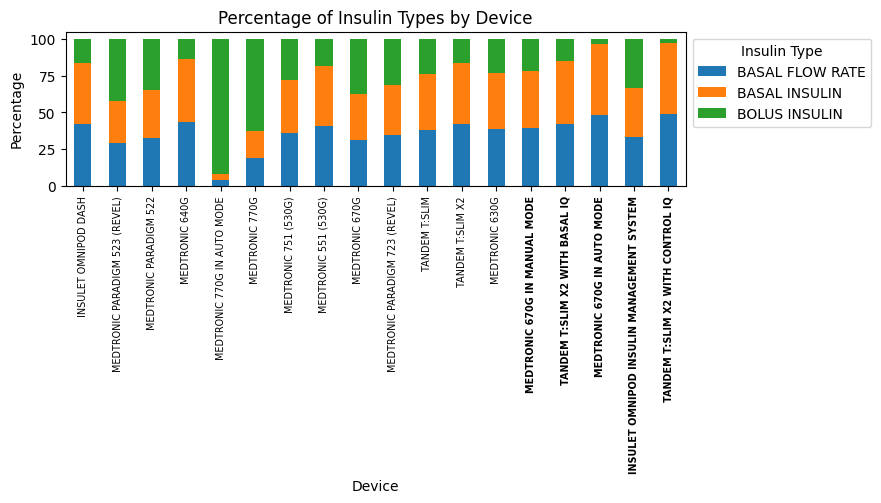

In [42]:
# insulin type per device
#pump_rows = facm.loc[~(facm.TRTMNT=='MDI')].copy()
r = pump_rows.value_counts(['DXTRT','FATEST'],sort=False)
print("Percentage of suspend basal insulin by device")
r = r.unstack(level=1)
r = 100*r.div(r.sum(axis=1), axis=0)

#sort by number of patients per platform
patients_per_platform = pump_rows.groupby('DXTRT').USUBJID.nunique().sort_values()
r = r.loc[patients_per_platform.index]

plt.figure(figsize=(8,2)); ax=plt.gca()
r.plot(kind='bar', stacked=True, ax=ax)
plt.title('Percentage of Insulin Types by Device')
plt.ylabel('Percentage')
plt.xlabel('Device')
plt.legend(title='Insulin Type', loc='upper left', bbox_to_anchor=(1,1))
plt.xticks(fontsize='x-small')

# Make the font bold for the last five x-tick labels
xticks = ax.get_xticklabels()
for label in xticks[-5:]:
    label.set_fontweight('bold')

#save file 
file = os.path.join(os.getcwd(),'..','..','docs','data_sets','assets','t1dexi_insulin_types_by_device.png')
plt.savefig(file)


### ...summary 
**Patients**:  
- The distributions show
- number of events:
    - not vastly different
    - 1039 has very few, but other users affected too
- Maximum Basal Gaps
    - very normal
- TDDs
    - two extreme exceptions
- Durations
    - On further inspection, we saw that some patients have extremely high durations 
    - This causes wrong high basal deliveries
    - High durations often happen as last basal value
    - however, 556 is an exception from this rule (here, one example actually causes overlaps, which we haven't removed yet)

**Dates:**
 - The days have either no basal or only limited basal, some have a few boluses.

**Conclusion**
 - There is no general trend that would support removing these patients
 - Number of days might be a better criterion
 - Extremely long durations might need to be removed!
 - Some might be automatically resolved by using the overlap-removal discussed earlier


#### TDDs

/var/folders/m4/5d02b2xs0l52lbxzbk0t3vym0000gp/T/ipykernel_67081/3537144212.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tdds = pump_rows.groupby(['DXTRT','USUBJID','day']).apply(tdd)


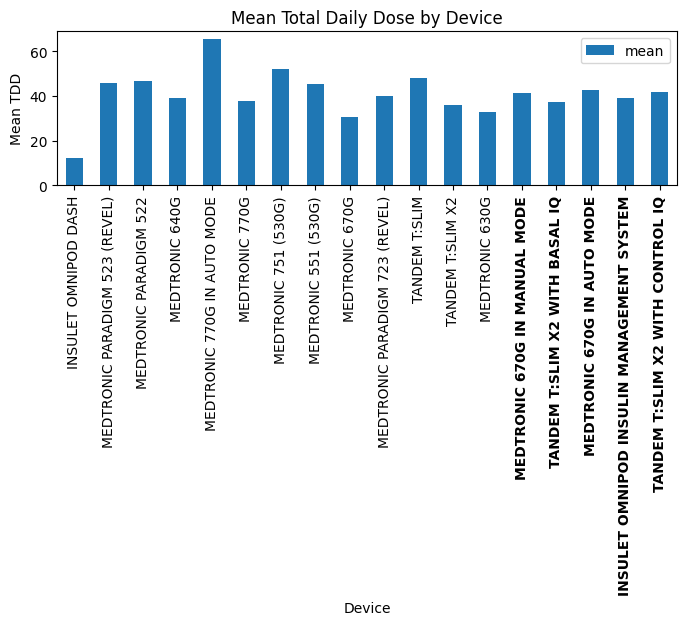

In [43]:
#TDDs
def tdd(df):
    bolus_tdd = df.loc[df.FATEST=='BOLUS INSULIN'].FAORRES.sum()
    basal_tdd = df.loc[df.FATEST=='BASAL INSULIN'].FAORRES.sum()
    return pd.Series({'Bolus TDD':bolus_tdd,'Basal TDD':basal_tdd})
tdds = pump_rows.groupby(['DXTRT','USUBJID','day']).apply(tdd)
mean_tdds_by_pump = tdds.sum(axis=1).groupby('DXTRT').agg(['mean'])

# Sort by the order of patients_per_platform
mean_tdds_by_pump = mean_tdds_by_pump.loc[patients_per_platform.index]
#display(mean_tdds_by_pump)

#draw as bar char
plt.figure(figsize=(8,2)); ax=plt.gca()
mean_tdds_by_pump.plot(kind='bar',ax=ax)
# draw std
plt.title('Mean Total Daily Dose by Device')
plt.ylabel('Mean TDD')
plt.xlabel('Device')


# Make the font bold for the last five x-tick labels
xticks = ax.get_xticklabels()
for label in xticks[-5:]:
    label.set_fontweight('bold')
plt.show()


### ... summary
- All pumps have basal flow rates, and boluses
- TDDs vary significantly
    - Many pumps have less than a handful of subjects 
- 770g has no insulin subtype
    - mostly boluses (does the AID system modulate it differently?)
    - Even 770g without "IN AUTO MODE" suffix (also in AID)?
- percentage of suspends is drastically different
    - highest in Tandem "with Basal IQ"

### Inocrrect Pump Labels?

The inconsistency observed above could also indicate incorret labeling of the pumps.
Let's look at the distributions.

In [44]:
# Draw patients average daily event counts per device
num_events = facm.groupby(['DXTRT', 'USUBJID','day']).size()
num_events = num_events.groupby(level=[0,1]).mean()

plt.figure(figsize=(12, 6))
for i,dxtrt in enumerate(num_events.index.levels[0]):
    subset = num_events.loc[dxtrt]
    pump_type = pump_type.loc[pump_type.USUBJID.isin(subset.index)]
    plt.scatter([dxtrt] * len(subset), subset, label=f'{i}:{dxtrt}',alpha=0.5)

plt.xlabel('DXTRT')
plt.ylabel('Number of Events')
plt.title('Patients average number of daily events by DXTRT')
#plt.xticks(rotation=90)
xticks = np.arange(len(num_events.index.levels[0]))
plt.xticks(xticks, xticks)
plt.legend(title='DXTRT', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.yscale('log')

#plt.hlines([100],0,18)

#save figure
file = os.path.join(os.getcwd(),'..','..','docs','data_sets','assets','t1dexi_daily_events_by_device.png')
plt.savefig(file, bbox_inches='tight')

NameError: name 'pump_type' is not defined

<Figure size 1200x600 with 0 Axes>

In [406]:
#show non AID patients with more than 100 events (potential mislabels)
temp = pd.merge(num_events.reset_index().rename(columns={0:'EVENTS'}),treatment.drop(columns='DXTRT'),on='USUBJID')

display(temp.loc[(temp.EVENTS>100) & (temp.TRTMNT!='AID')])
display(temp.loc[(temp.EVENTS<100) & (temp.TRTMNT=='AID')])

,DXTRT,USUBJID,EVENTS,TRTMNT
134,MEDTRONIC 670G IN AUTO MODE,304,369.035714,CSII
159,MEDTRONIC 670G IN MANUAL MODE,1656,108.642857,CSII


,DXTRT,USUBJID,EVENTS,TRTMNT
332,TANDEM T:SLIM X2 WITH CONTROL IQ,1193,13.678571,AID
362,TANDEM T:SLIM X2 WITH CONTROL IQ,1444,87.357143,AID
444,TANDEM T:SLIM X2 WITH CONTROL IQ,558,90.892857,AID
456,TANDEM T:SLIM X2 WITH CONTROL IQ,677,49.214286,AID


We see that there are many pumps that seem to fall in both categories.
- Tandem with Basal IQ shows much less events than other AIDs but more than CSII (this makes sens because it has comes with additional suspend events)
- Some Tandem with Control IQ seem to be not in AID (1193,1444,5558,677 with <100 events/day)
- One 770G outlier could be AID (subject 304 with 369 events/day in average)

The netiob script reassigns one subject. However, we saw that this subject was already correctly assigned in our copy of the data.
>        # [Discretional]. We observed that subject ID: 766 device type should be 'MEDTRONIC 770G IN AUTO MODE' and we updated as such
>        device_data.loc[device_data['USUBJID'] == '766', 'DXTRT'] = 'MEDTRONIC 770G IN AUTO MODE'


DXTRT
MEDTRONIC 670G IN AUTO MODE    194.785714
dtype: float64

USUBJID
354    159.571429
856     54.464286
dtype: float64

Text(0.5, 0, 'bolus dose (U)')

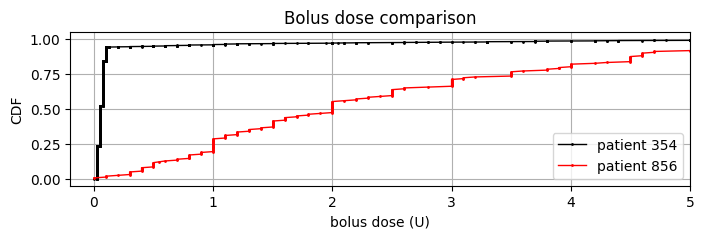

In [39]:
#look at rows for 770G patients of interes
display(num_events.loc[:,'766'])
display(num_events.loc['MEDTRONIC 770G'])

#compare patients 354 and 856
plt.figure(figsize=(8,2)); ax=plt.gca()
#cdf.plot_cdf(facm.loc[facm.USUBJID == '354'].FATEST,ax=ax)
cdf.plot_cdf(facm.loc[(facm.USUBJID == '354') & (facm.FATEST =='BOLUS INSULIN')].FAORRES,ax=ax, label='patient 354')
cdf.plot_cdf(facm.loc[(facm.USUBJID == '856') & (facm.FATEST =='BOLUS INSULIN')].FAORRES,ax=ax, label='patient 856',color='red')
plt.xlim(-.2,5); plt.legend(); plt.title('Bolus dose comparison'); plt.xlabel('bolus dose (U)')
#This looks like micro bolusing.

Looks like patient 354 has many more small boluses indicating AID use (micro boluses).
Lets's compare the three AID pumps:

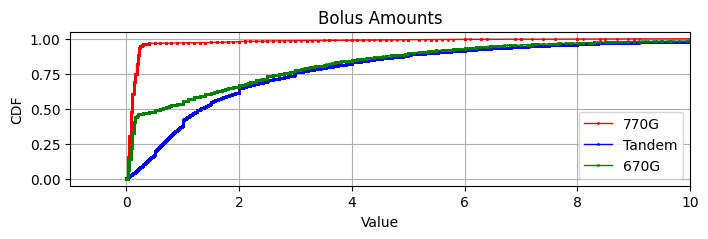

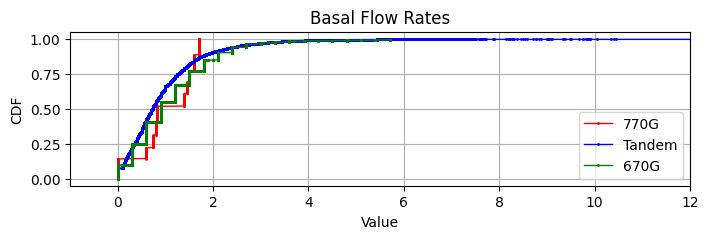

In [249]:
#CDF for 770g, 670g and tandem
df_77g = facm.loc[facm.DXTRT=='MEDTRONIC 770G IN AUTO MODE']
df_tandem = facm.loc[facm.DXTRT=='TANDEM T:SLIM X2 WITH CONTROL IQ']
df_670g = facm.loc[facm.DXTRT=='MEDTRONIC 670G IN AUTO MODE']

#compare cdf for boluses of both pumps
plt.figure(figsize=(8,2)); ax=plt.gca()
cdf.plot_cdf(df_77g.loc[df_77g.FATEST=='BOLUS INSULIN'].FAORRES,ax=ax,label='770G',color='red')
cdf.plot_cdf(df_tandem.loc[df_tandem.FATEST=='BOLUS INSULIN'].FAORRES,ax=ax,label='Tandem',color='blue')
cdf.plot_cdf(df_670g.loc[df_670g.FATEST=='BOLUS INSULIN'].FAORRES,ax=ax,label='670G',color='green')
plt.title('Bolus Amounts'); ax.legend();ax.set_xlim(-1,10)    

# save figure
file = os.path.join(os.getcwd(),'..','..','docs','data_sets','assets','t1dexi_bolus_amounts_three_pumps.png')
plt.savefig(file)

#compare basals
plt.figure(figsize=(8,2)); ax=plt.gca()
cdf.plot_cdf(df_77g.loc[df_77g.FATEST=='BASAL FLOW RATE'].FAORRES,ax=ax,label='770G',color='red')
cdf.plot_cdf(df_tandem.loc[df_tandem.FATEST=='BASAL FLOW RATE'].FAORRES,ax=ax,label='Tandem',color='blue')
cdf.plot_cdf(df_670g.loc[df_670g.FATEST=='BASAL FLOW RATE'].FAORRES,ax=ax,label='670G',color='green')
plt.title('Basal Flow Rates'); ax.legend(); ax.set_xlim(-1,12)    

# save figure
file = os.path.join(os.getcwd(),'..','..','docs','data_sets','assets','t1dexi_basal_flow_rates_three_pumps.png')
plt.savefig(file)

While there are big differences between the pumps. These are likely due to different implementaitons of AID. While 770g does a lot of micro bolusing, tandem uses variable flow rates.

### ... summary
 - While the script re-assigns user=766 to 'MEDTRONIC 770G IN AUTO MODE', this was already correctly assigned in our dataset.
 - The average daily events varies significantly
 - Some pumps are potential candidates for incorrect assignment
    - e.g. patient 354 could be AID
    - some tandem pumps might actually be in manual mode  (1193,1444,5558,677 with <100 events/day)

### Suspends?
Now, we want to check how to deal with suspend events.

We will look at how the suspend events look in context by plotting the surrounding data.

Percentage of basal suspends


/var/folders/m4/5d02b2xs0l52lbxzbk0t3vym0000gp/T/ipykernel_55179/1583459866.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  r = pump_rows.groupby('DXTRT').apply(lambda x: 100*x.INSSTYPE.str.contains('suspend', na=False).sum()/(x.FACAT=='BASAL').sum())#.sort_values('INSSTYPE',ascending=False)


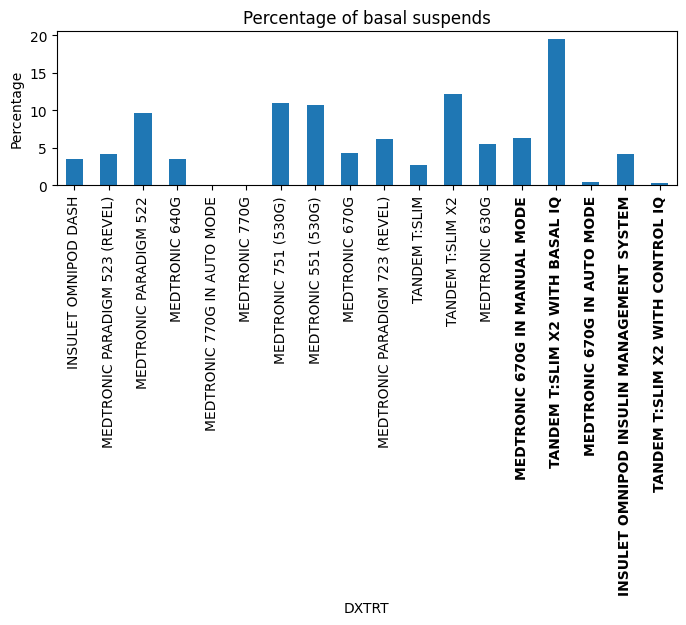

In [266]:
#suspends
#pump_rows = facm.loc[~(facm.ISMDI)].copy()
r = pump_rows.groupby('DXTRT').apply(lambda x: 100*x.INSSTYPE.str.contains('suspend', na=False).sum()/(x.FACAT=='BASAL').sum())#.sort_values('INSSTYPE',ascending=False)

print("Percentage of basal suspends")

#sort by number of patients per platform
r  = r.loc[patients_per_platform.index]

plt.figure(figsize=(8,2)); ax=plt.gca()
r.plot(kind='bar', legend=False,ax=ax)
plt.ylabel('Percentage')
plt.title('Percentage of basal suspends')


# Make the font bold for the last five x-tick labels
xticks = ax.get_xticklabels()
for label in xticks[-5:]:
    label.set_fontweight('bold')

#save figure
file = os.path.join(os.getcwd(),'..','..','docs','data_sets','assets','t1dexi_basal_suspends_by_device.png')
plt.savefig(file, bbox_inches='tight')

In [214]:
#do we have suspends in deliveries and flow rates?
suspend_rows = facm.loc[facm.INSSTYPE.str.contains('suspend',na=False)]
display(suspend_rows.value_counts(['FATEST','INSSTYPE'],sort=False))

FATEST         INSSTYPE
BASAL INSULIN  suspend     14457
Name: count, dtype: int64

In [215]:
#what are the values for suspends?

suspend_rows.value_counts(subset=['FATEST','FAORRES'],dropna=False)

FATEST         FAORRES
BASAL INSULIN  NaN        13940
               0.0          517
Name: count, dtype: int64

,FATEST,INSSTYPE,FADTC,FADUR,FAORRES
636615,BASAL FLOW RATE,NaN,2019-11-30 14:41:45,0 days 03:39:02,1.000
636616,BASAL FLOW RATE,NaN,2019-11-30 18:20:47,0 days 01:03:50,NaN
636617,BASAL FLOW RATE,NaN,2019-11-30 19:24:37,0 days 01:12:09,1.000
636618,BASAL FLOW RATE,NaN,2019-11-30 20:36:46,0 days 00:30:00,NaN
637501,BASAL INSULIN,suspend,2019-11-30 14:37:06,0 days 00:04:39,NaN
637502,BASAL INSULIN,scheduled,2019-11-30 14:41:45,0 days 03:39:02,3.651
637503,BASAL INSULIN,suspend,2019-11-30 18:20:47,0 days 01:03:50,NaN
637504,BASAL INSULIN,scheduled,2019-11-30 19:24:37,0 days 01:12:09,1.203


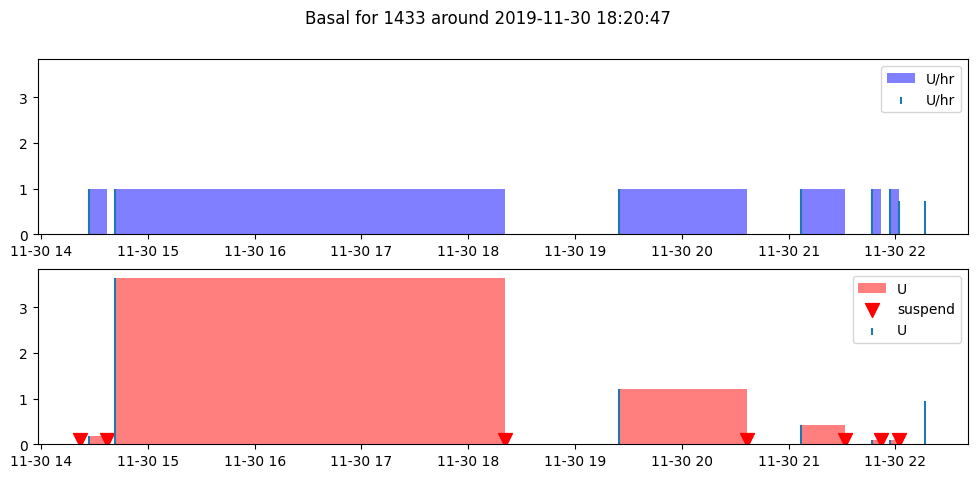

In [ ]:
#draw basal and suspend events

sample = suspend_rows.sample(1)

subject = sample.USUBJID.values[0]
datetime = pd.to_datetime(sample.FADTC.values[0])
window = timedelta(hours=4)

context = facm.loc[(facm.USUBJID==subject) & (facm.FACAT == 'BASAL') & (facm.FADTC >= (datetime-window)) & (facm.FADTC<=(datetime+window))].sort_values('FADTC')

#plt.figure(figsize=(20,4)); ax=plt.gca(); twinx = ax.twinx()
fig, AX = plt.subplots(2,1,figsize=(12, 5),sharey=True)
ax=AX[0]; twinx = AX[1]

#draw flow rates
temp = context.loc[context.FATEST=='BASAL FLOW RATE']
drawing.drawBasal(ax,temp.FADTC, temp.FAORRES,label='U/hr')

# draw individual basal deliveries
temp = context.loc[context.FATEST=='BASAL INSULIN']
drawing.drawBasal(twinx,temp.FADTC, temp.FAORRES,label='U',color='red')

#add suspend markers
temp = temp.loc[temp.INSSTYPE.str.contains('suspend',na=False)]
twinx.scatter(temp.FADTC, [0.1]*len(temp), color='red', marker='v', s=100,label='suspend')
ax.legend(); twinx.legend()

#show the events before and after the suspend
iloc = context.index.get_loc(sample.index[0])
display(context.iloc[iloc-4:iloc+4][['FATEST','INSSTYPE','FADTC','FADUR','FAORRES']].sort_values(['FATEST','FADTC']))
plt.suptitle(f'Basal for {subject} around {datetime}')

# save figure
#file = os.path.join(os.getcwd(),'..','..','docs','data_sets','assets','t1dexi_suspend_example.png')
#plt.savefig(file)

In [218]:
## show the FAORRES for the BASAL FLOW RATES at the same time
flow_rate_suspends = pd.merge(suspend_rows[['USUBJID','FADTC']], facm.loc[facm.FATEST=='BASAL FLOW RATE'], 
                              on=['USUBJID','FADTC'])#,suffixes=('','_flow_rate'))
flow_rate_suspends.value_counts('FAORRES',dropna=False)

FAORRES
NaN      13944
0.000      517
0.675        1
Name: count, dtype: int64

### ... summary
- insulin type is suspend only in the deliveries, not the flow rates
- suspend FAORRESS values are are NaN or 0
- suspends are equally reflected in flow rates

How to work with Suspends:  
1. Don't need to be manually calculated
2. NaN values need to be replaced with zeros

### Duplicates
we did see that often there are duplicated rows (in basal also with different durations altnerating between 0 and a bigger value). Let;s check how to get rid of them
#inspect duplicates

In [48]:
#inspect duplicates
dup_rows = facm.loc[facm.duplicated(subset=['USUBJID','FADTC','FATEST'],keep=False)]
print(f"{100*len(dup_rows)/len(facm):.2f}% of rows are duplicates")

#type counts
display(dup_rows.FATEST.value_counts())

#patient counts
#compare against those being removed by netiob scripts: usubjid_to_remove = ['1039', '1046', '1439', '317', '422', '956'] # List of subjects t be removed
display(dup_rows.USUBJID.value_counts())

#check how many differences exist in each column
print(f"There are {len(dup_rows)} duplicated rows")
print("The number of differences in each column are:")
numDiffs = (dup_rows.groupby(['USUBJID','FADTC']).nunique().map(lambda x: max(x-1,0)))#.drop(columns=['USUBJID','FADTC'])
display(numDiffs.sum())

0.10% of rows are duplicates


FATEST
BASAL FLOW RATE    1109
BASAL INSULIN      1109
BOLUS INSULIN         2
Name: count, dtype: int64

USUBJID
856     1068
862      600
354      284
1335     108
953       48
1224      14
80        12
312       12
1434       8
716        8
576        8
1647       8
1139       8
556        4
1072       4
1603       4
159        4
1568       4
1426       4
1385       4
1714       4
71         2
Name: count, dtype: int64

There are 2220 duplicated rows
The number of differences in each column are:


FATESTCD    554
FATEST      554
FAOBJ         0
FACAT         0
FAORRES     859
FAORRESU    554
FADUR       555
INSDVSRC      0
INSSTYPE      4
INSNMBOL      0
INSEXBOL      0
DXTRT         0
ISMDI         0
day           0
INSMNBL       1
dtype: int64

In [49]:
#Let's look at the two bolusses
dup_rows.loc[dup_rows.FATEST=='BOLUS INSULIN']

,USUBJID,FATESTCD,FATEST,FAOBJ,FACAT,FAORRES,FAORRESU,FADTC,FADUR,INSDVSRC,INSSTYPE,INSNMBOL,INSEXBOL,DXTRT,ISMDI,day,INSMNBL
1814493,71,INSBOLUS,BOLUS INSULIN,INSULIN,BOLUS,0.20,U,2020-07-31 07:43:00,NaT,Pump,normal,NaN,NaN,INSULET OMNIPOD INSULIN MANAGEMENT SYSTEM,False,2020-07-31,0.20
1814494,71,INSBOLUS,BOLUS INSULIN,INSULIN,BOLUS,0.15,U,2020-07-31 07:43:00,NaT,Pump,normal,NaN,NaN,INSULET OMNIPOD INSULIN MANAGEMENT SYSTEM,False,2020-07-31,0.15


In [50]:
#show examples for the basal flow rates

#let's focus on basal flow rates
#dup_basal_flows = dup_rows.loc[dup_rows.FATEST=='BASAL FLOW RATE']
row = dup_rows.sample()

subject = row.USUBJID.values[0]
date = row.FADTC.dt.date.values[0]
index = row.index[0]
print(index)

#display rows surrounding the duplicate
context = facm.loc[(facm.USUBJID==subject) & (facm.FADTC.dt.date == date) & (facm.FACAT=='BASAL')].sort_values('FADTC')
i = context.index.get_loc(index)
display(context.iloc[i-3:i+4])

476077


,USUBJID,FATESTCD,FATEST,FAOBJ,FACAT,FAORRES,FAORRESU,FADTC,FADUR,INSDVSRC,INSSTYPE,INSNMBOL,INSEXBOL,DXTRT,ISMDI,day,INSMNBL
476252,1335,INSBASAL,BASAL INSULIN,INSULIN,BASAL,0.000,U,2020-10-22 04:00:00,0 days 00:00:00,Pump,NaN,NaN,NaN,MEDTRONIC 770G IN AUTO MODE,False,2020-10-22,NaN
476253,1335,INSBASAL,BASAL INSULIN,INSULIN,BASAL,2.625,U,2020-10-22 04:00:00,0 days 03:30:00,Pump,NaN,NaN,NaN,MEDTRONIC 770G IN AUTO MODE,False,2020-10-22,NaN
476076,1335,BASFLRT,BASAL FLOW RATE,INSULIN,BASAL,0.800,U/hr,2020-10-22 07:30:00,0 days 00:00:00,NaN,NaN,NaN,NaN,MEDTRONIC 770G IN AUTO MODE,False,2020-10-22,NaN
476077,1335,BASFLRT,BASAL FLOW RATE,INSULIN,BASAL,0.800,U/hr,2020-10-22 07:30:00,0 days 07:20:00,NaN,NaN,NaN,NaN,MEDTRONIC 770G IN AUTO MODE,False,2020-10-22,NaN
476255,1335,INSBASAL,BASAL INSULIN,INSULIN,BASAL,5.867,U,2020-10-22 07:30:00,0 days 07:20:00,Pump,NaN,NaN,NaN,MEDTRONIC 770G IN AUTO MODE,False,2020-10-22,NaN
476254,1335,INSBASAL,BASAL INSULIN,INSULIN,BASAL,0.000,U,2020-10-22 07:30:00,0 days 00:00:00,Pump,NaN,NaN,NaN,MEDTRONIC 770G IN AUTO MODE,False,2020-10-22,NaN
476078,1335,BASFLRT,BASAL FLOW RATE,INSULIN,BASAL,0.800,U/hr,2020-10-22 14:50:00,0 days 00:10:00,NaN,NaN,NaN,NaN,MEDTRONIC 770G IN AUTO MODE,False,2020-10-22,NaN


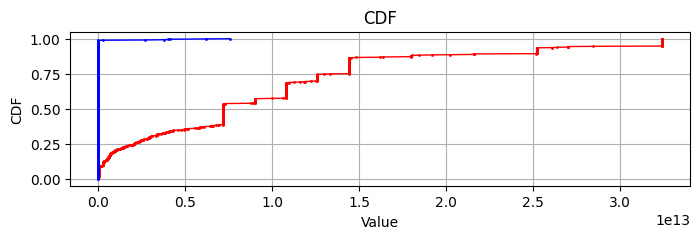

In [51]:
#let's compare how the maximum and non-maximum durations differ
from src import pandas_helper
from src import cdf
dup_rows_flow_rates = dup_rows.loc[dup_rows.FATEST=='BASAL FLOW RATE']
(i,i_max,i_drop) = pandas_helper.get_duplicated_max_indexes(dup_rows_flow_rates, ['USUBJID','FADTC','FATEST'],'FADUR')

plt.figure(figsize=(8,2)); ax=plt.gca()
cdf.plot_cdf(dup_rows_flow_rates.drop(i_drop).FADUR, label='max durs', color='red',ax=ax)
cdf.plot_cdf(dup_rows_flow_rates.drop(i_max).FADUR, label='non max durs',color='blue',ax=ax)

Yes, the non maximum values are mostly zero.

### ... summary
 - ~0.1 % duplicates
    - domindated by a handful of patients
 - Only basal duplicates (2 bolus exceptions) to be ignored
 - When duplciates exist, they exist for deliveries and flow rates
   - Assumption: once a incorrect flow rate was reported, the delivery was also incorrectly duplicated
- Duplciates show a pattern:
    - Duration: One row comes with 0 duration (probbaly wrong), the other row with a larger duration (that fits the start of the  next value)
    - Dose: The BASAL deliveries then also have a wrong entry with a zero FAORRES (amount) value (cant divide by zero)

How to deal with duplicates?
 - Use the row with the maximum duration

### Corrupt data?
The netiob script removes some patient and date combinations. 
 - Which subjects and dates are being removed and why?


#### Dropped patients

The netiob script removes some patients. 
> usubjid_to_remove = ['1039', '1046', '1439', '317', '422', '956'] # List of subjects t be removed
> df = df[~df['USUBJID'].isin(usubjid_to_remove)]   
Unfortunately, we don't know why they are removed. Let's check if we should do the same.


In [269]:
usubjid_to_remove = ['1039', '1046', '1439', '317', '422', '956'] # List of subjects t be removed

Number of events for patients to remove


/var/folders/m4/5d02b2xs0l52lbxzbk0t3vym0000gp/T/ipykernel_55179/4113469431.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.annotate(txt, (temp[i], np.random.choice([0.2,0.4,.6])), fontsize=8)


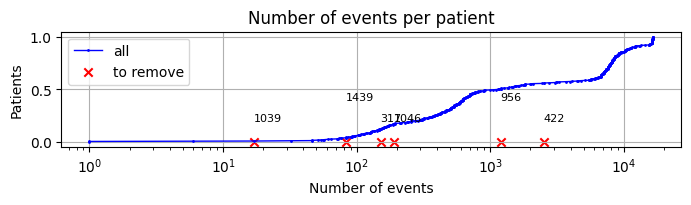

In [279]:
#number of events overall

#number of events (overall)
plt.figure(figsize=(8,1.5)); ax=plt.gca()
print('Number of events for patients to remove')
num_events_overall = facm.groupby('USUBJID').size()
#display(num_events_overall[usubjid_to_remove])

#draw distribution 
#plt.scatter(num_events_overall,[1]*len(num_events_overall), color='gray',alpha=0.1,label='all')
cdf.plot_cdf(num_events_overall, ax=ax,color='blue',label='all')
plt.scatter(num_events_overall.loc[usubjid_to_remove], [0]*len(usubjid_to_remove),label='to remove', color='red', marker ='x')
#plt.ylim(0.8,1.2); plt.xscale('log');
#add subject name as text
temp = num_events_overall.loc[usubjid_to_remove]
for i, txt in enumerate(temp.index):
    ax.annotate(txt, (temp[i], np.random.choice([0.2,0.4,.6])), fontsize=8)
plt.legend()
plt.xscale('log')
plt.title('Number of events per patient'); plt.xlabel('Number of events'); plt.ylabel('Patients')

# save figure
file = os.path.join(os.getcwd(),'..','..','docs','data_sets','assets','t1dexi_number_of_events_per_patient.png')
plt.savefig(file, bbox_inches='tight')

Except for patient 1039, none of the patients stand out.

Maximum Basal Gap:


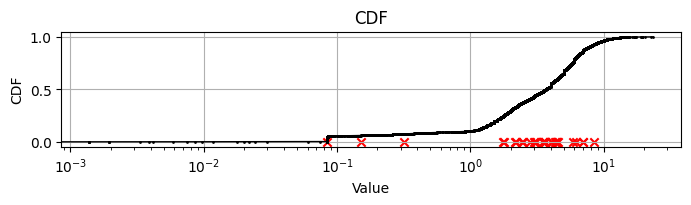

In [271]:
#check for basal gaps
basal_gaps = facm.sort_values('FADTC').groupby(['USUBJID','day']).FADTC.agg(lambda x: x.diff().max())
basal_gaps = basal_gaps.dropna().dt.total_seconds()/3600

print('Maximum Basal Gap:')
plt.figure(figsize=(8,1.5)); ax=plt.gca()
cdf.plot_cdf(basal_gaps, ax=ax)
temp = basal_gaps.loc[usubjid_to_remove]
plt.scatter(temp,[0]*len(temp),marker='x', color='red')
plt.xscale('log')

The daily maximum gaps are not particularly large for the users to be removed. 

Number of days for patients to remove


/var/folders/m4/5d02b2xs0l52lbxzbk0t3vym0000gp/T/ipykernel_55179/18416551.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.annotate(txt, (temp[i], np.random.choice([0.2,0.4,.6])), fontsize=8)
/var/folders/m4/5d02b2xs0l52lbxzbk0t3vym0000gp/T/ipykernel_55179/18416551.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(); plt.title('Number of days per patient');


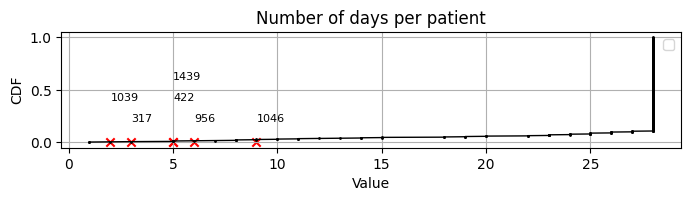

In [276]:
#number of days
plt.figure(figsize=(8,1.5)); ax=plt.gca()
print('Number of days for patients to remove')
num_days = facm.groupby(['USUBJID']).day.nunique()

#draw distribution 
cdf.plot_cdf(num_days,ax=ax)
temp = num_days.loc[usubjid_to_remove]
plt.scatter(temp,[0]*len(temp),marker='x', color='red');
for i, txt in enumerate(temp.index):
    ax.annotate(txt, (temp[i], np.random.choice([0.2,0.4,.6])), fontsize=8)
plt.legend(); plt.title('Number of days per patient');

The number of days are very short. THis might be a better criterion!

#### TDD distributions

Total Daily Dose for patients to remove


,,,Bolus TDD,Basal TDD
DXTRT,USUBJID,day,,
INSULET OMNIPOD INSULIN MANAGEMENT SYSTEM,1046,2021-01-18,3.75,187.380
TANDEM T:SLIM X2,317,2019-03-01,7.47,324.298


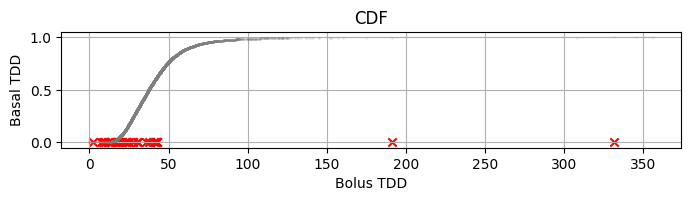

In [278]:
#draw tdd distribution
plt.figure(figsize=(8,1.5)); ax=plt.gca()

print('Total Daily Dose for patients to remove')
cdf.plot_cdf(tdds.sum(axis=1),color='gray',alpha=0.1,ax=ax)
#plt.hexbin(tdds['Bolus TDD'],tdds['Basal TDD'],xscale='log',yscale='log',gridsize=100)
#plt.yscale('log'); plt.xscale('log')

#add markers for patients to remove
temp = tdds.loc[:,usubjid_to_remove,:].copy()
display(temp.loc[temp.sum(axis=1)>150])
plt.scatter(temp.sum(axis=1),[0]*len(temp), marker='x',color='red')
plt.xlabel('Bolus TDD'); plt.ylabel('Basal TDD');
#plt.xscale('log') 
#add text 

#save figure
file = os.path.join(os.getcwd(),'..','..','docs','data_sets','assets','t1dexi_tdd_per_patient.png')
plt.savefig(file, bbox_inches='tight')


Two strong outliers >200 Units, some very small values. 

,USUBJID,FATESTCD,FAORRES,FAORRESU,FADTC,FADUR
1282080,317,INSBASAL,1.151,U,2019-03-01 11:40:39,0 days 01:00:03
1282019,317,BASFLRT,1.150,U/hr,2019-03-01 11:40:39,0 days 01:00:03
1282020,317,BASFLRT,0.460,U/hr,2019-03-01 12:40:42,28 days 19:41:01
1282081,317,INSBASAL,318.174,U,2019-03-01 12:40:42,28 days 19:41:01


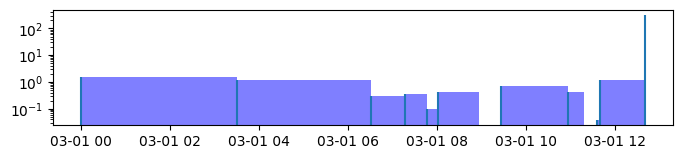

In [283]:
#inspect patient 317 on day 2019-03-01
from datetime import datetime
plt.figure(figsize=(8,1.5)); ax=plt.gca()
temp = facm.loc[(facm.USUBJID=='317') & (facm.day==datetime(2019,3,1).date())]
display(temp.loc[temp.FACAT=='BASAL'][['USUBJID','FATESTCD','FAORRES','FAORRESU','FADTC','FADUR']].sort_values('FADTC').tail(4))

basals= temp.loc[temp.FATEST=='BASAL INSULIN'].sort_values('FADTC')
drawing.drawBasal(ax,basals.FADTC,basals.FAORRES)
plt.yscale('log')

##save figure
file = os.path.join(os.getcwd(),'..','..','docs','data_sets','assets','t1dexi_basals_317_2019-03-01.png')

plt.savefig(file, bbox_inches='tight')

The last value is obviously wrong, it is calculated off of a basal rate with a very long duration.
Let's check if the long durations are always the very last reported basal rate.

In [165]:
#for max durations, check distance to last basal event
high_durations = facm.loc[facm.FADUR>timedelta(hours=24)]
max_durs = high_durations.groupby(['USUBJID']).apply(lambda x: x.loc[x.FADUR==x.FADUR.max()].FADTC.values[0]-x.FADTC.max())
max_durs.dropna()

/var/folders/m4/5d02b2xs0l52lbxzbk0t3vym0000gp/T/ipykernel_44548/3218986515.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  max_durs = high_durations.groupby(['USUBJID']).apply(lambda x: x.loc[x.FADUR==x.FADUR.max()].FADTC.values[0]-x.FADTC.max())


USUBJID
1046      0 days 00:00:00
1161      0 days 00:00:00
1283      0 days 00:00:00
1649      0 days 00:00:00
313       0 days 00:00:00
317       0 days 00:00:00
504       0 days 00:00:00
556    -13 days +12:46:00
897       0 days 00:00:00
95        0 days 00:00:00
dtype: timedelta64[ns]

We see that for most patients, the last duration is the max duration with one exception.

,USUBJID,FATESTCD,FATEST,FAOBJ,FACAT,FAORRES,FAORRESU,FADTC,FADUR,INSDVSRC,INSSTYPE,INSNMBOL,INSEXBOL,DXTRT,ISMDI,day,INSMNBL
1619999,556,BASFLRT,BASAL FLOW RATE,INSULIN,BASAL,0.95,U/hr,2021-01-13 06:00:00,14 days 18:00:00,NaN,NaN,NaN,NaN,INSULET OMNIPOD INSULIN MANAGEMENT SYSTEM,False,2021-01-13,NaN
1620028,556,BASFLRT,BASAL FLOW RATE,INSULIN,BASAL,0.51,U/hr,2021-01-25 17:14:00,2 days 02:21:00,NaN,NaN,NaN,NaN,INSULET OMNIPOD INSULIN MANAGEMENT SYSTEM,False,2021-01-25,NaN


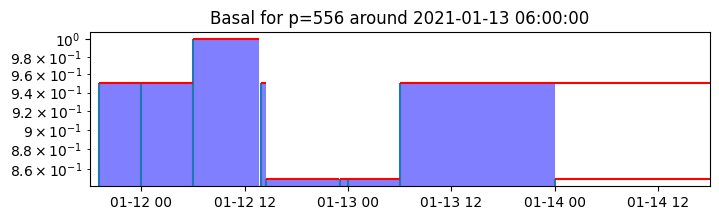

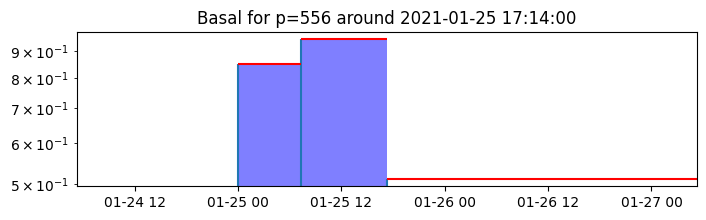

In [195]:
#let's look at the exception:
def draw_data_in_context(df,datetime,subject,hours, fatest_type='BASAL FLOW RATE',ax=None):
    if ax is None:
        plt.figure(figsize=(8,2)); ax=plt.gca()

    sub_frame = df.loc[(df.USUBJID==subject) 
                       & (df.FATEST == fatest_type)
                       & (df.FADTC < datetime+timedelta(hours=hours)) 
                       & (df.FADTC > datetime-timedelta(hours=hours))].sort_values('FADTC')
    sub_frame.sort_values('FADTC')
    if fatest_type == 'BASAL FLOW RATE' or fatest_type == 'BASAL INSULIN':
        drawing.drawBasal(ax,sub_frame.FADTC, sub_frame.FAORRES)
        # draw the durations as horizontal lines
        for i, row in sub_frame.iterrows():
            ax.hlines(row.FAORRES, row.FADTC, row.FADTC+row.FADUR, color='red')
    ax.set_xlim((datetime-timedelta(hours=hours),datetime+timedelta(hours=hours)))
    return ax

#get the rows for which the maximum duration is greater than 24 hours
temp = facm.loc[(facm.USUBJID=='556') & (facm.FATEST=='BASAL FLOW RATE')].sort_values('FADTC')
sample = temp.loc[temp.FADUR>timedelta(hours=24)]
display(sample)

for row in sample.itertuples():
    draw_data_in_context(facm, row.FADTC, row.USUBJID, 36, fatest_type='BASAL FLOW RATE')
    plt.yscale('log')
    plt.title(f'Basal for p={row.USUBJID} around {row.FADTC}')


#### Dropped dates
The netiob script drops certain dates, lets take a look at them 

Subject 1193 on 2020-04-13 has no basal flow rates
Subject 1611 on 2019-07-30 has no boluses
Subject 550 on 2021-02-15 has no basal flow rates
Subject 576 on 2019-02-20 has no boluses


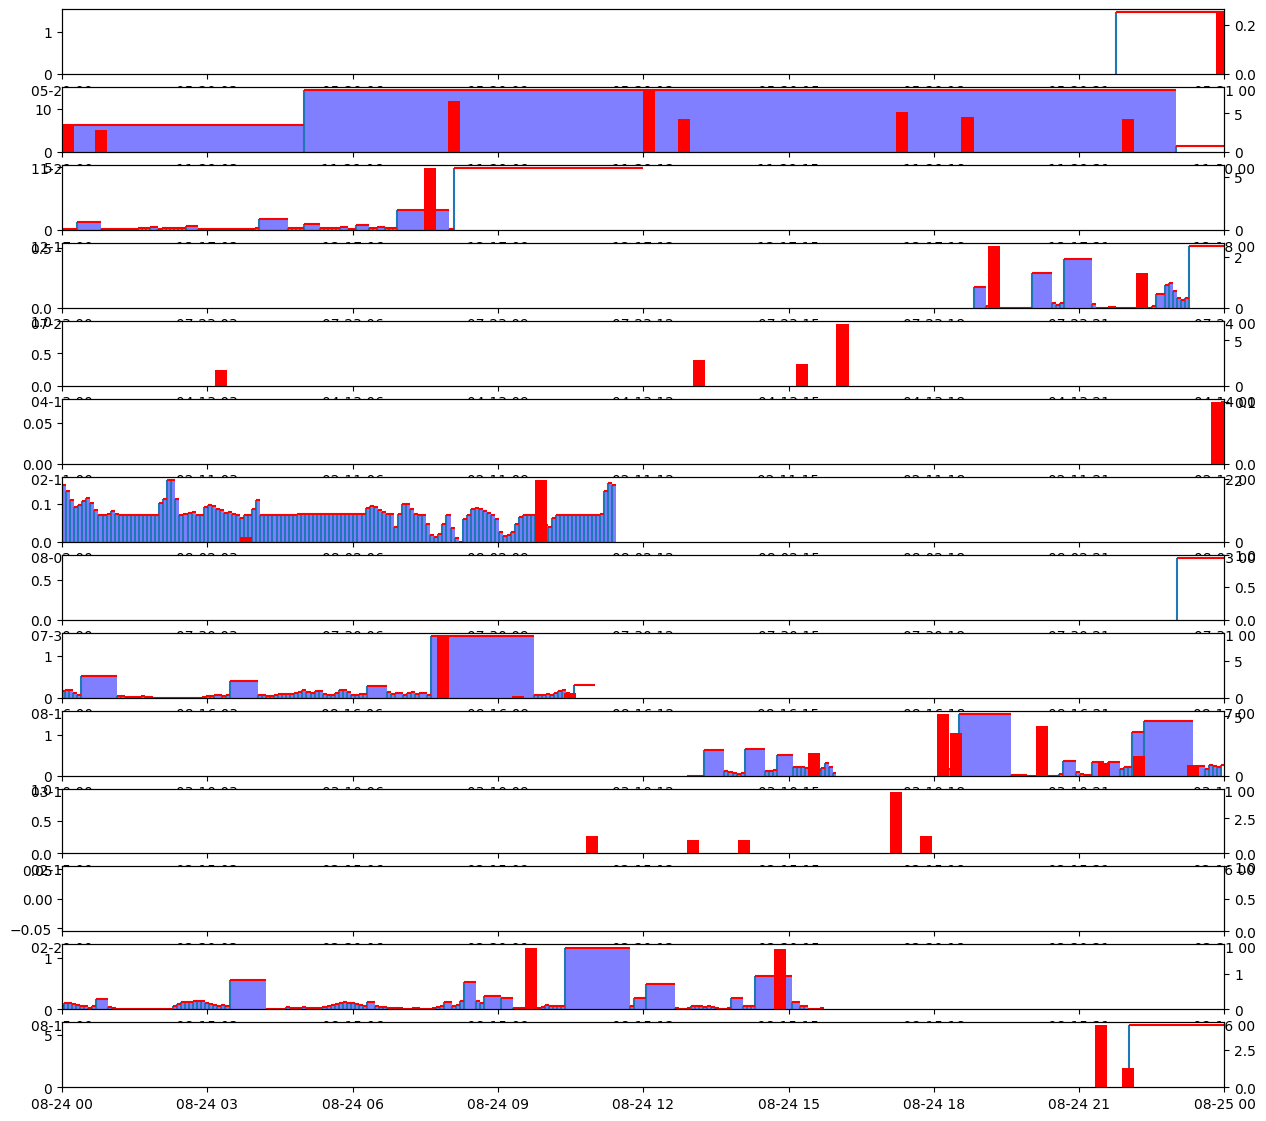

In [213]:
items_to_be_tossed = {
    '1016': ['2020-05-20'], 
    '946': ['2019-11-29', '2019-11-28'],
    '1076': ['2019-12-17'], 
    '1127': ['2019-07-23'], 
    '1193': ['2020-04-13', '2020-04-14'],
    '1248': ['2020-02-11'],
    '1542': ['2020-08-02'],
    '1611': ['2019-07-30'],
    '1615': ['2019-08-16'],
    '183': ['2020-03-10'],
    '550': ['2021-02-15', '2021-02-16', '2021-02-17', '2021-02-18', '2021-02-19', 
            '2021-02-20', '2021-02-21', '2021-02-22'],
    '576': ['2019-02-20', '2019-02-21'],
    '692': ['2020-08-15'],
    '945': ['2019-08-24']}

f, AX = plt.subplots(len(items_to_be_tossed),1,figsize=(15, 1*len(items_to_be_tossed)))#,sharey=True)
for i,(subject, date_strings) in enumerate(items_to_be_tossed.items()):
    ax = AX[i]; twinx = ax.twinx()
    date = datetime.strptime(date_strings[0],'%Y-%m-%d').date()
    #print(f"Subject {subject} on {date}")
    sub_frame = facm.loc[(facm.USUBJID==subject) & (facm.day == date)].sort_values('FADTC')
    basal = sub_frame.loc[sub_frame.FATEST=='BASAL INSULIN']
    bolus = sub_frame.loc[sub_frame.FATEST=='BOLUS INSULIN']
    if len(basal)>0:
        drawing.drawBasal(ax,basal.FADTC, basal.FAORRES)
        for i, row in basal.iterrows():
            ax.hlines(row.FAORRES, row.FADTC, row.FADTC+row.FADUR, color='red')
    else: 
        print(f"Subject {subject} on {date} has no basal flow rates")
    
    if len(bolus)>0:
        drawing.drawBoluses(twinx, bolus.FADTC, bolus.FAORRES)
    else:
        print(f"Subject {subject} on {date} has no boluses")
    ax.set_xlim((date,date+timedelta(days=1)))

## ...summary 
**Patients**:  
- The distributions show
- number of events:
    - not vastly different
    - 1039 has very few, but other users affected too
- Maximum Basal Gaps
    - very normal
- TDDs
    - two extreme exceptions
- Durations
    - On further inspection, we saw that some patients have extremely high durations 
    - This causes wrong high basal deliveries
    - High durations often happen as last basal value
    - however, 556 is an exception from this rule (here, one example actually causes overlaps, which we haven't removed yet)

**Dates:**
 - The days have either no basal or only limited basal, some have a few boluses.

**Conclusion**
 - There is no general trend that would support removing these patients
 - Number of days might be a better criterion
 - Extremely long durations might need to be removed!
 - Some might be automatically resolved by using the overlap-removal discussed earlier


## Glucose Data

In [ ]:
#lb = self._get_data('LB')[0][['USUBJID', 'LBORRES', 'LBORRESU', 'LBDTC']]
lb = pd.read_sas(os.path.join(t1dexi_path,'LB.xpt'), encoding='latin-1')
lb['LBDTC'] = lb['LBDTC'].apply(lambda x: datetime(1960, 1, 1) + timedelta(seconds=x) if pd.notnull(x) else pd.NaT)
lb.replace('', np.nan, inplace=True)
lb = lb[['USUBJID','LBCAT','LBORRES','LBDTC']]
lb = lb.loc[lb.LBCAT=='CGM']
lb.drop(columns='LBCAT',inplace=True)

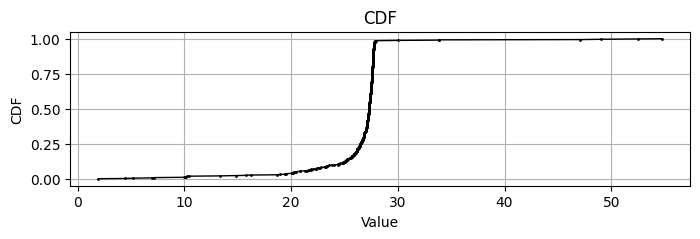

In [ ]:
## how many days worth of data do patients have?
day_equivalent_num_cgms = (lb.groupby('USUBJID').size()/(24*12)).sort_values(ascending=False)
plt.figure(figsize=(8,2)); ax=plt.gca()
cdf.plot_cdf(day_equivalent_num_cgms,ax=ax)

0.15 % of the values are below 41
0.23 % of the values are above 400


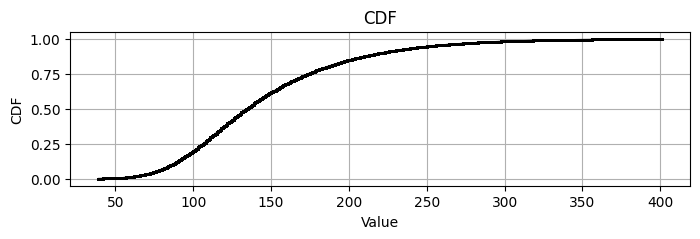

In [ ]:
## CGM distribution
plt.figure(figsize=(8,2)); ax=plt.gca()
cdf.plot_cdf(lb.LBORRES,ax=ax)
print(f'{100*(lb.LBORRES<=41).sum()/len(lb):.2f} % of the values are below 41')
print(f'{100*(lb.LBORRES>=400).sum()/len(lb):.2f} % of the values are above 400')

There are 18 duplicated cgms


,USUBJID,LBORRES,LBDTC
1783394,1698,241.0,2020-02-12 12:38:58
1783395,1698,241.0,2020-02-12 12:38:58
2154463,313,121.0,2020-03-11 23:06:56
2154464,313,129.0,2020-03-11 23:06:56


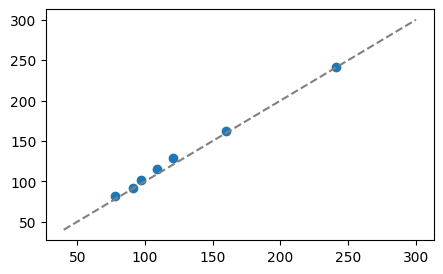

In [ ]:
## duplicates
temp = lb.loc[lb.duplicated(subset=['USUBJID','LBDTC'],keep=False)]
print(f"There are {len(temp)} duplicated cgms")
display(temp.head(4))

def get_min_max_duplicates(df,dup_cols,val_col):
    dups = df[df.duplicated(subset=dup_cols, keep=False)]
    results = dups.groupby(dup_cols)[val_col].agg(['min','max'])
    return results

dup_min_max = get_min_max_duplicates(lb,['USUBJID','LBDTC'],'LBORRES')
plt.figure(figsize=(5,3)); ax=plt.gca()
ax.plot([40,300],[40,300], '--', color='gray')
ax.scatter(dup_min_max['min'], dup_min_max['max'])


They are more or less the same, also really few, drop using first

In [ ]:
## drop duplicates
lb = lb.drop_duplicates(subset=['USUBJID','LBDTC'],keep='first')

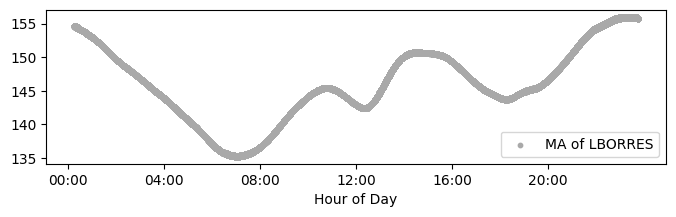

In [ ]:
## check for distribution of CGM values
reload(drawing)
plt.figure(figsize=(8,2)); ax=plt.gca()
drawing.drawMovingAverage(ax,lb,'LBDTC','LBORRES')

In [ ]:
lb

,USUBJID,LBORRES,LBDTC
0,1,115.0,2020-05-11 00:01:17
1,1,109.0,2020-05-11 00:06:17
2,1,105.0,2020-05-11 00:11:17
3,1,106.0,2020-05-11 00:16:18
4,1,110.0,2020-05-11 00:21:18
...,...,...,...
3785749,988,89.0,2021-04-16 23:36:40
3785750,988,94.0,2021-04-16 23:41:40
3785751,988,95.0,2021-04-16 23:46:40
3785752,988,93.0,2021-04-16 23:51:40


### Summary Glucose
LB is a very simple dataframe:  
- Glucose is in local time
- all in mg/dl
- No nan values 
- Hb1A1c must be dropped
- only a couple temporal duplicates which are dropped (using first) as they correlate perfectly

## Collected Questions & Answers

**Answered Questions**  
- The script only considers FATEST == 'BASAL INSULIN' thus ignoring BASAL FLOW RATE. Is this correct?
      - This is because flow rates are equivalent to the deliveries
- Why is FASTRES Nan when FAORRESU is U/hr but not when it is U?
  - This is because FASTRES represents a standard unit and U/hr is not supported, use the original unit FAORRESU instead.
- There are no 0 FASTRESN values but many NaN. How are 0 basal rates reported?
  - It appears as if NaN Basal Flow Rates (at least for Pump users) mark zero values. 
- Why are some boluses only in FAORRES but not in INSNMBOL and INSEXBOL
  - It appears as if these boluses were not properly classified. This is true for at least 26% of the boluses
  - However, it is unclear why.
- We see that sometimes, FATEST and sometimes FACAT are used to to identify BASAL or BOLUS. Are there difference between FATEST and FACAT? 
    - No, the columns are identical. 
- We see that there are different rules used between 670G and Tandem vs. 770G to select basal and boluses. Are there differences between the pumps and which column conditions to use?
    - No, specifying specific INSTYPE does not seem to make much sense. In fact it would exclude 16% NaN rows (most of which are MDI). We don't know why they are NaN but don;t see eveidence that these rows are wrong. 
    - Recommendation: Do not use INSTYPE to sub-select basal rows. 
- We see temporal Boluses and Basal duplicates, what should we do?
    - Only two bolsues, ignore.
    - 0.1% basal duplicates. It appears as if there are incorrect rows with zero delivery duration. Therefore, keep those with maximum duration. 


**Open Questions:**  
The script re-assigns a patient. Why?
  - Our dataset already has the right pump label. Probably the data was changed.
Some dates are being removed. 
 - It is unclear why but we found that these 
5. In 770G, the Basal (FACAT == Basal) duration (FADUR) is calculated as it it is missing for other pumps.

- AID
  - Why are `TANDEM T:SLIM X2 WITH BASAL IQ` not considered AID?
  - How do we know if Pump was running AID or not?
- BASAL
    - Why are there many rows with NaN values in `FASTRESN` for FATEST being BASAL INSULIN or BASAL FLOW RATE?
- Why are there MDI patients with basal flow Rates
  - The values are NaN but we don't know why there are these empty rows.

netiob specific:
    - Why did netiob excluded basal rows without INSTYPE ? These are 16% of all basals, mostly MDI


learnings
1. FACAT and FATEST, are identical (they use different acronyms but are consistent), use only one of them.
2. Do not use INSTYPE to sub-select basal rows because some INSTYPE are NaN and we don't want to miss them. Use FATEST or FACAT instead. 
